In [1]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
import argparse
import numpy as np
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True

import yaml
import time
import os
from keras import backend as K
from keras.models import Model
from keras.optimizers import SGD, Adam, RMSprop
import hyperparameters
import mol_utils as mu
import mol_callbacks as mol_cb
from keras.callbacks import CSVLogger
from models import encoder_model, load_encoder
from models import decoder_model, load_decoder
from models import varLayer, load_varLayer
from models import property_predictor_model, load_property_predictor
from models import variational_layers, varLayer
from functools import partial
from keras.layers import Lambda

/home/hengshi/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/hengshi/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/hengshi/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/hengshi/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:5

In [2]:
from rdkit import Chem

In [2]:
params = hyperparameters.load_params("../models/zinc/exp.json")

Using hyper-parameters:
name                      - zinc        
MAX_LEN                   - 120         
data_file                 - 250k_rndm_zinc_drugs_clean_3.csv
char_file                 - zinc.json   
encoder_weights_file      - zinc_encoder.h5
decoder_weights_file      - zinc_decoder.h5
varlayer_weights_file     - zinc_varlayer.h5
test_idx_file             - test_idx.npy
history_file              - history.csv 
checkpoint_path           - ./          
do_prop_pred              - False       
TRAIN_MODEL               - True        
ENC_DEC_TEST              - False       
PADDING                   - right       
RAND_SEED                 - 42          
epochs                    - 10          
vae_annealer_start        - 29          
dropout_rate_mid          - 0.08283292970479479
anneal_sigmod_slope       - 0.5106654305791392
recurrent_dim             - 488         
batch_size                - 126         
lr                        - 0.00039192162392520126
hidden_dim           

In [3]:
MAX_LEN = params['MAX_LEN']

CHARS = yaml.safe_load(open("../models/zinc/zinc.json"))
params['NCHARS'] = len(CHARS)
NCHARS = len(CHARS)
CHAR_INDICES = dict((c, i) for i, c in enumerate(CHARS))

In [5]:
CHAR_INDICES.keys()

dict_keys(['7', '6', 'o', ']', '3', 's', '(', '-', 'S', '/', 'B', '4', '[', ')', '#', 'I', 'l', 'O', 'H', 'c', '1', '@', '=', 'n', 'P', '8', 'C', '2', 'F', '5', 'r', 'N', '+', '\\', ' '])

In [1]:
pwd

'/nfs/turbo/umms-welchjd/hengshi/perturb_gan/chemical_vae-master_newTrain/chemvae_newTrain_train'

In [6]:
params['do_prop_pred'] and ('data_file' in params)

False

In [2]:
import os

In [3]:
import pandas as pd
path_data = '/nfs/turbo/umms-welchjd/hengshi/GAN/data/sciPlex/sciPlex3/'
data_188 = pd.read_csv(os.path.join(path_data, 'emb_named_chemvae_canonize.csv'))
chem_188 = list(data_188['Structure_Canonize'])

In [ ]:
data_188.head()

In [34]:
len([i for i in chem_188 if len(i) > 120])

2

In [8]:
smiles = mu.load_smiles_and_data_df('../models/zinc/250k_rndm_zinc_drugs_clean_3.csv', MAX_LEN)

In [8]:
smiles

['CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1',
 'C[C@@H]1CC(Nc2cncc(-c3nncn3C)c2)C[C@@H](C)C1',
 'N#Cc1ccc(-c2ccc(O[C@@H](C(=O)N3CCCC3)c3ccccc3)cc2)cc1',
 'CCOC(=O)[C@@H]1CCCN(C(=O)c2nc(-c3ccc(C)cc3)n3c2CCCCC3)C1',
 'N#CC1=C(SCC(=O)Nc2cccc(Cl)c2)N=C([O-])[C@H](C#N)C12CCCCC2',
 'CC[NH+](CC)[C@](C)(CC)[C@H](O)c1cscc1Br',
 'COc1ccc(C(=O)N(C)[C@@H](C)C/C(N)=N/O)cc1O',
 'O=C(Nc1nc[nH]n1)c1cccnc1Nc1cccc(F)c1',
 'Cc1c(/C=N/c2cc(Br)ccn2)c(O)n2c(nc3ccccc32)c1C#N',
 'C[C@@H]1CN(C(=O)c2cc(Br)cn2C)CC[C@H]1[NH3+]',
 'CCOc1ccc(OCC)c([C@H]2C(C#N)=C(N)N(c3ccccc3C(F)(F)F)C3=C2C(=O)CCC3)c1',
 'Cc1ccc2nc(S[C@H](C)C(=O)NC3CCC(C)CC3)n(C)c(=O)c2c1',
 'O=C(N1CCc2c(F)ccc(F)c2C1)C1(O)Cc2ccccc2C1',
 'Cc1ccccc1C(=O)N1CCC2(CC1)C[C@H](c1ccccc1)C(=O)N2C',
 'CCCc1cc(NC(=O)CN2C(=O)NC3(CCC(C)CC3)C2=O)n(C)n1',
 'CC(C)Cc1nc(SCC(=O)NC[C@@H]2CCCO2)c2c(=O)n(C)c(=O)n(C)c2n1',
 'Cc1ccc(CNC(=O)c2ccccc2NC(=O)[C@@H]2CC(=O)N(c3ccc(C)cc3)C2)cc1',
 'CCCCC(=O)NC(=S)Nc1ccccc1C(=O)N1CCOCC1',
 'Cc1c(NC(=O)CSc2nc3sc4c(c3c(=O)[nH]2)CCCC4)c

In [11]:
# canonize
change = []
smiles_list = []
for i in range(len(smiles)):
    smile = mu.canon_smiles(smiles[i])
    if smiles[i] != smile:
        change.append(i)
    smiles_list.append(smile)

In [12]:
len(change)

20

In [13]:
len(smiles)

249455

In [49]:
charset_list = []

len_list = []
for i in smiles:
    for j in i:
        if j not in charset_list:
            charset_list.append(j)
    len_list.append(len(i))
max_len = max(len_list)

In [52]:
 set(list(CHAR_INDICES.keys())) - set(charset_list)

{' '}

In [9]:
data = pd.read_csv('../models/zinc/250k_rndm_zinc_drugs_clean_3.csv')
data.shape

(249455, 4)

In [12]:
data.head()

,smiles,logP,qed,SAS
0,CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1\n,5.05060,0.702012,2.084095
1,C[C@@H]1CC(Nc2cncc(-c3nncn3C)c2)C[C@@H](C)C1\n,3.11370,0.928975,3.432004
2,N#Cc1ccc(-c2ccc(O[C@@H](C(=O)N3CCCC3)c3ccccc3)...,4.96778,0.599682,2.470633
3,CCOC(=O)[C@@H]1CCCN(C(=O)c2nc(-c3ccc(C)cc3)n3c...,4.00022,0.690944,2.822753
4,N#CC1=C(SCC(=O)Nc2cccc(Cl)c2)N=C([O-])[C@H](C#...,3.60956,0.789027,4.035182


In [13]:
max([len(i) for i in data['smiles']])

110

In [14]:
zinc_dc = pd.read_csv('/nfs/turbo/umms-welchjd/hengshi/perturb_gan/data/smiles/zinc_deepchem_molnet/zinc15_250K_2D.csv')
zinc_dc.head()

,smiles,zinc_id,mwt,logp,reactive,purchasable,tranche_name
0,CCN(CCSC)C(=O)N[C@@](C)(CC)C(F)(F)F,ZINC000933510105,286.363,3.112,0,20,CGAD
1,CC1(C)CN(C(=O)Nc2cc3ccccc3nn2)C[C@@]2(CCOC2)O1,ZINC000888615590,342.399,2.432,0,20,EEAD
2,CC[C@H](NC(C)=O)C(=O)NCC1(NC(=O)Cc2nonc2C)CC1,ZINC001432326999,337.380,-0.400,0,20,EBAD
3,O=C(N[C@@H]1CC[C@H](F)C1)[C@H]1C[C@@H]1c1ccc2c...,ZINC000345651486,305.349,2.568,0,20,DFAD
4,COCC(=O)N(C)CC(=O)NCC1(Nc2nccn3nnnc23)CC1,ZINC001110378235,348.367,-1.315,0,20,EAAD


In [16]:
max([len(i) for i in zinc_dc['smiles']])

93

In [24]:
zinc_dc_list = list(zinc_dc['smiles'])

In [25]:
charset_dc_list = []

len_dc_list = []
for i in zinc_dc_list:
    for j in i:
        if j not in charset_dc_list:
            charset_dc_list.append(j)
    len_dc_list.append(len(i))
max_dc_len = max(len_dc_list)

In [26]:
max_dc_len

93

In [27]:
path_zinc = '/nfs/turbo/umms-welchjd/hengshi/perturb_gan/data/smiles/zinc_deepchem_molnet/'
zinc_name = 'zinc_dc_canon.csv'
zinc_pd = pd.read_csv(os.path.join(path_zinc, zinc_name))
zinc_dc_canon = list(zinc_pd.iloc[:, 1])

In [28]:
charset_dcc_list = []

len_dcc_list = []
for i in zinc_dc_canon:
    for j in i:
        if j not in charset_dcc_list:
            charset_dcc_list.append(j)
    len_dcc_list.append(len(i))
max_dcc_len = max(len_dcc_list)

In [32]:
len(charset_dcc_list), len(charset_dc_list)

(34, 33)

In [37]:
list_diff = [i for i in range(len(zinc_dc_canon)) if zinc_dc_canon[i] != zinc_dc_list[i]]

In [40]:
len(zinc_dc_canon)

250000

In [41]:
use = []
for i in range(len(zinc_dc_canon)):
    i_data = zinc_dc_canon[i]
    if '7' in i_data:
        use.append(i)

In [44]:
zinc_dc_list[use[0]], zinc_dc_canon[use[0]]

('Cc1ncc(CN2CC(NC(=O)[C@H]3[C@H]4[C@@H]5C[C@H]6[C@@H]3[C@H]3C[C@@H]6[C@@H]5[C@H]43)C2)o1',
 'Cc1ncc(CN2CC(NC(=O)[C@H]3[C@H]4[C@@H]5C[C@@H]6[C@@H]7C[C@@H]([C@@H]4[C@@H]75)[C@@H]63)C2)o1')

In [35]:
set(charset_dcc_list) - set(charset_dc_list)

{'7'}

In [34]:
charset_dc_list

['C',
 'N',
 '(',
 'S',
 ')',
 '=',
 'O',
 '[',
 '@',
 ']',
 'F',
 '1',
 'c',
 '2',
 '3',
 'n',
 'H',
 'o',
 '4',
 '-',
 '#',
 's',
 'l',
 '+',
 '/',
 '\\',
 'B',
 'r',
 'P',
 'i',
 '5',
 'I',
 '6']

In [36]:
charset_dcc_list

['C',
 'N',
 '(',
 'S',
 ')',
 '=',
 'O',
 '[',
 '@',
 ']',
 'F',
 '1',
 'c',
 '2',
 '3',
 'n',
 'H',
 'o',
 '4',
 '-',
 '#',
 's',
 'l',
 '+',
 '/',
 '\\',
 'B',
 'r',
 'P',
 'i',
 '5',
 'I',
 '6',
 '7']

In [54]:
set(charset_list) - set(charset_dcc_list) 

{'8'}

In [55]:
 set(charset_dcc_list) - set(charset_list) 

{'i'}

In [8]:
X = mu.smiles_to_hot(smiles, MAX_LEN, params[
                             'PADDING'], CHAR_INDICES, NCHARS)

In [69]:
smiles_list_trans = []
for i in chem_188:
    if '.' in i:
        smile = ''
        for j in i: 
            if j != '.':
                smile += j
        smiles_list_trans.append(smile)
    else:
        smiles_list_trans.append(i)

In [70]:
smiles_list_trans1 = []
for i in smiles_list_trans:
    if '*' in i:
        smile = ''
        for j in i: 
            if j != '*':
                smile += j
        smiles_list_trans1.append(smile)
    else:
        smiles_list_trans1.append(i)

In [71]:
smiles_list_trans2 = []
for i in smiles_list_trans1:
    if 'a' in i:
        smile = ''
        for j in i: 
            if j != 'a':
                smile += j
        smiles_list_trans2.append(smile)
    else:
        smiles_list_trans2.append(i)

In [40]:

for i in range(len(smiles_list_trans2)):
    if len(smiles_list_trans2[i]) > 120:
        temp = smiles_list_trans2[i][:120]
        smiles_list_trans2[i] = temp
        
    

In [41]:
X188 = mu.smiles_to_hot(smiles_list_trans2, MAX_LEN, params[
                             'PADDING'], CHAR_INDICES, NCHARS)

In [43]:
np.save("/nfs/turbo/umms-welchjd/hengshi/perturb_gan/chemical_vae-master_newTrain/OnehotData_188.npy", X188)

In [18]:
# images
path_images = '/nfs/turbo/umms-welchjd/hengshi/perturb_gan/data/cell_image'
smiles_img = np.load(os.path.join(path_images, 'UniqueSMILES.npy'), allow_pickle=True)

In [20]:
smiles_img.shape

(82,)

In [21]:
# canonize
change = []
smiles_list = []
for i in range(len(smiles_img)):
    smile = mu.canon_smiles(smiles_img[i])
    if smiles_img[i] != smile:
        change.append(i)
    smiles_list.append(smile)

In [23]:
len(change)

78

In [24]:
charset_list = []

len_list = []
for i in smiles_list:
    for j in i:
        if j not in charset_list:
            charset_list.append(j)
    len_list.append(len(i))
max_len = max(len_list)

In [27]:
(np.array(len_list) > 120).sum(), len(len_list)

(1, 82)

In [28]:
 set(list(CHAR_INDICES.keys())) - set(charset_list)

{' ', '6', '7', '8', 'P'}

In [29]:
set(charset_list) -  set(list(CHAR_INDICES.keys())) 

{'.'}

In [32]:
for i in smiles_list:
    if '.' in i:
        print(i)
        print(len(i))

C[n+]1c2cc(N)ccc2cc2ccc(N)cc21.Nc1ccc2cc3ccc(N)cc3nc2c1
55


In [35]:
MAX_LEN

120

In [36]:
smiles_list_trans = []
for i in smiles_list:
    
    if len(i) > MAX_LEN:
        i = i[:MAX_LEN]
    if '.' in i:
        smile = ''
        for j in i: 
            if j != '.':
                smile += j
        smiles_list_trans.append(smile)
    else:
        smiles_list_trans.append(i)

In [39]:
XImg = mu.smiles_to_hot(smiles_list_trans, MAX_LEN, params['PADDING'], CHAR_INDICES, NCHARS)

In [40]:
XImg.shape

(82, 120, 35)

In [42]:
np.save(os.path.join(path_images, "OnehotData_Imgs.npy"), XImg)

In [43]:
path_images

'/nfs/turbo/umms-welchjd/hengshi/perturb_gan/data/cell_image'

In [38]:
len(hot_data)

188

In [39]:
hot_data[0].shape

(40, 120, 35)

In [110]:
import pandas as pd
smiles = pd.read_csv('/nfs/turbo/umms-welchjd/hengshi/perturb_gan/data/LINCS/oneHot/GSE92742_Broad_LINCS_Level3_INF_mlr12k_n1319138x12328_processed_UniqueCanonicalSmiles.csv')

In [111]:
smiles

,Unnamed: 0,0
0,0,CCCN1CCCC2Cc3n[nH]cc3CC21
1,1,O=C1CC(Oc2ccccc12)c3ccccc3
2,2,C[C@@H]1O[C@@H](OC[C@H]2O[C@@H](Oc3c(oc4cc(O)c...
3,3,N(Cc1ccccc1)c1ncnc2nc[nH]c12
4,4,C[C@@H](NC(=O)/C(=C/c1ccc(O)c(O)c1)/C#N)c2ccccc2
...,...,...
20325,20325,OC(=O)[C@@]1(Cc2cccc(Nc3nccs3)n2)CC[C@@H](CC1)...
20326,20326,CN(C)CCOc1ccc(cc1)C(=C(/CCCl)c1ccccc1)\c1ccccc1
20327,20327,COc1cc(Nc2ncc3CN=C(c4cc(Cl)ccc4-c3n2)c2c(F)ccc...
20328,20328,CC1(C)Oc2ccc3C4=C[C@@]56NC(=O)[C@]7(CCCN7C5=O)...


In [113]:
smiles_list = list(smiles.iloc[:, 1])

In [114]:
# canonize
smiles_c_list = []
change_list = []
for i in range(len(smiles_list)):
    
    if smiles_list[i] != 'restricted':
        smile = mu.canon_smiles(smiles_list[i])
        if smiles_list[i] != smile:
            change_list.append(i)
        smiles_c_list.append(smile)

In [115]:
len(change_list)

17939

In [116]:
len(smiles_list), len(smiles_c_list)

(20330, 20329)

In [117]:
smiles_list = smiles_c_list

In [118]:
charset_list = []

len_list = []
for i in smiles_list:
    for j in i:
        if j not in charset_list:
            charset_list.append(j)
    len_list.append(len(i))
max_len = max(len_list)

In [119]:
charset_lincs_list = charset_list.copy()

In [120]:
smiles_linc_list = smiles_list

In [97]:
specialLincsList = list(set(charset_list) - set(CHARS))

In [98]:
set(CHARS) - set(charset_list)

{' '}

In [99]:
specialLincsList

['g', 'a', 'A', '.', 'd', 't', 'u', 'M', 'i', 'L', 'e']

In [22]:
smiles_list_trans = []
for t in specialLincsList:
    a = 0
    for i in smiles_list:
        if t in i:
            a += 1
    smiles_list_trans.append(a)



In [25]:
pd.DataFrame({'Token': specialLincsList, 'Number': smiles_list_trans})

,Token,Number
0,g,3
1,a,1
2,A,5
3,.,136
4,d,1
5,t,2
6,u,2
7,M,1
8,i,19
9,L,1


In [32]:
# shorter than MAX_LEN
smiles_list_trans = []
for t in specialLincsList:
    a = 0
    for i in smiles_list:
        if (t in i) & (len(i) <= MAX_LEN):
            a += 1
    smiles_list_trans.append(a)


In [33]:
pd.DataFrame({'Token': specialLincsList, 'Number': smiles_list_trans})

,Token,Number
0,g,3
1,a,0
2,A,5
3,.,33
4,d,1
5,t,2
6,u,2
7,M,1
8,i,19
9,L,1


In [34]:
np.sum( smiles_list_trans)

68

In [40]:
np.where(np.array(smiles_list) == 'restricted')

(array([], dtype=int64),)

In [25]:
# remove non-occuring tokens
for t in specialLincsList:
    smiles_list_trans = []
    for i in smiles_list:
        if t in i:
            smile = ''
            for j in i: 
                if j != t:
                    smile += j
            smiles_list_trans.append(smile)
        else:
            smiles_list_trans.append(i)
    smiles_list = smiles_list_trans

In [26]:
charset_list = []

len_list = []
for i in smiles_list:
    for j in i:
        if j not in charset_list:
            charset_list.append(j)
    len_list.append(len(i))
max_len = max(len_list)

In [37]:
len(smiles_list)

20329

In [31]:
(np.array(len_list) <= MAX_LEN).sum()

20065

In [32]:
XLINCS = mu.smiles_to_hot(smiles_list, MAX_LEN, params[
                             'PADDING'], CHAR_INDICES, NCHARS)

In [33]:
XLINCS.shape

(20065, 120, 35)

In [34]:
np.save('/nfs/turbo/umms-welchjd/hengshi/perturb_gan/data/LINCS/oneHot/GSE92742_Broad_LINCS_Level3_INF_mlr12k_n1319138x12328_processed_UniqueCanonicalSmilesOneHot.npy', XLINCS)

In [36]:
np.where(np.array(len_list) <= MAX_LEN)[0]

array([    0,     1,     3, ..., 20326, 20327, 20328])

In [38]:
smiles_unique = pd.read_csv('/nfs/turbo/umms-welchjd/hengshi/perturb_gan/data/LINCS/oneHot/GSE92742_Broad_LINCS_Level3_INF_mlr12k_n1319138x12328_processed_UniqueCanonicalSmiles.csv')
smiles_u = list(smiles_unique.iloc[:, 1])
smiles_ui = [i for i in smiles_u if i != 'restricted']


In [40]:
np.array(smiles_ui)[np.where(np.array(len_list) <= MAX_LEN)[0]].shape

(20065,)

In [41]:
np.save('/nfs/turbo/umms-welchjd/hengshi/perturb_gan/data/LINCS/oneHot/GSE92742_Broad_LINCS_Level3_INF_mlr12k_n1319138x12328_processed_UniqueCanonicalSmilesOneHotSmiles.npy', np.array(smiles_ui)[np.where(np.array(len_list) <= MAX_LEN)[0]])

# PubChem 10M 


In [57]:
path_zinc = '/nfs/turbo/umms-welchjd/hengshi/perturb_gan/data/smiles/pubchem'
zinc_name = 'pubchem_canon.csv'

In [58]:
import pandas as pd
import numpy as np

In [59]:
# Canonization
pubchem_data = pd.read_csv(os.path.join(path_zinc, zinc_name))
pubchem_data.shape

(9999999, 2)

In [60]:
key_use = list(CHAR_INDICES.keys())

In [61]:
key_use

['7',
 '6',
 'o',
 ']',
 '3',
 's',
 '(',
 '-',
 'S',
 '/',
 'B',
 '4',
 '[',
 ')',
 '#',
 'I',
 'l',
 'O',
 'H',
 'c',
 '1',
 '@',
 '=',
 'n',
 'P',
 '8',
 'C',
 '2',
 'F',
 '5',
 'r',
 'N',
 '+',
 '\\',
 ' ']

In [62]:
smiles_list = list(pubchem_data.iloc[:, 1])

In [62]:
charset_list = []

len_list = []
for i in smiles_list:
    for j in i:
        if j not in charset_list:
            charset_list.append(j)
    len_list.append(len(i))
max_len = max(len_list)

In [63]:
len(charset_list)

62

In [64]:
len(list(set(charset_list) - set(key_use)))

31

In [65]:
len(list(set(key_use) - set(charset_list)))

4

In [67]:
len(charset_list)

62

In [19]:
pd.DataFrame(len_list).describe()

,0
count,9.999999e+06
mean,4.457236e+01
std,2.124516e+01
min,3.000000e+00
25%,3.300000e+01
50%,4.000000e+01
75%,5.100000e+01
max,3.536000e+03


In [20]:
len(len_list)

9999999

In [21]:
(np.array(len_list) <= 120)

array([ True,  True,  True, ...,  True,  True,  True])

In [22]:
pd.DataFrame(len_list).iloc[(np.array(len_list) <= 120), :].describe()

,0
count,9.916685e+06
mean,4.348125e+01
std,1.593098e+01
min,3.000000e+00
25%,3.200000e+01
50%,4.000000e+01
75%,5.100000e+01
max,1.200000e+02


In [23]:
# 
zinc_data = pd.read_csv('../250k_rndm_zinc_drugs_clean_3.csv')

In [24]:
zinc_data.head()

,smiles,logP,qed,SAS
0,CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1\n,5.05060,0.702012,2.084095
1,C[C@@H]1CC(Nc2cncc(-c3nncn3C)c2)C[C@@H](C)C1\n,3.11370,0.928975,3.432004
2,N#Cc1ccc(-c2ccc(O[C@@H](C(=O)N3CCCC3)c3ccccc3)...,4.96778,0.599682,2.470633
3,CCOC(=O)[C@@H]1CCCN(C(=O)c2nc(-c3ccc(C)cc3)n3c...,4.00022,0.690944,2.822753
4,N#CC1=C(SCC(=O)Nc2cccc(Cl)c2)N=C([O-])[C@H](C#...,3.60956,0.789027,4.035182


In [25]:
list_zinc = list(zinc_data['smiles'])

In [26]:
charset_zinc_list = []

len_zinc_list = []
for i in list_zinc:
    for j in i:
        if j not in charset_zinc_list:
            charset_zinc_list.append(j)
    len_zinc_list.append(len(i))
max_zinc_len = max(len_zinc_list)

In [27]:
pd.DataFrame(len_zinc_list).describe()

,0
count,249455.000000
mean,45.310461
std,9.326142
min,10.000000
25%,39.000000
50%,45.000000
75%,51.000000
max,110.000000


In [28]:
list(set(charset_zinc_list) - set(key_use))

['\n']

In [29]:
list(set(key_use) - set(charset_zinc_list) )

[' ']

In [30]:
len(smiles_list), len(len_list)

(9999999, 9999999)

In [68]:
charset_list = []
len_list = []
smile_less_120_list = []
for i in range(len(smiles_list)):
    smile = smiles_list[i]
    if len(smile) > 140:
        smile = smile[:140]
    for j in smile:
        if j not in charset_list:
            charset_list.append(j)
    len_list.append(len(smile))
    smile_less_120_list.append(smile)
max_len = max(len_list)

In [69]:
len(smile_less_120_list)

9999999

In [70]:
pd.DataFrame(len_list).describe()

,0
count,9.999999e+06
mean,4.424816e+01
std,1.794518e+01
min,3.000000e+00
25%,3.300000e+01
50%,4.000000e+01
75%,5.100000e+01
max,1.400000e+02


In [71]:
len(list(set(charset_list) - set(key_use)))

31

In [47]:
import os
path_onehot = '/nfs/turbo/umms-welchjd/hengshi/perturb_gan/data/smiles/onehot/PubChem10M'
data_all = np.load(os.path.join(path_onehot, "OnehotData_188.npy"))


In [48]:
path_data = '/nfs/turbo/umms-welchjd/hengshi/GAN/data/sciPlex/sciPlex3/'
import pandas as pd
import numpy as np
trt_whole_list = list(pd.read_csv(os.path.join(path_data, 'emb_named_PathwayLibrary.csv'))['treatment'])

In [49]:
indice_trt = np.where(np.array(trt_whole_list) == trt_whole_list[0])[0][0]
anno_trt = np.tile(data_all[[indice_trt]], (100, 1))

In [50]:
anno_trt = np.tile(data_all[[indice_trt]], (100, 1, 1))
anno_trt.shape

(100, 140, 63)

In [51]:
data_all.shape

(188, 140, 63)

In [52]:
list(set(key_use) - set(charset_list) )

[' ']

In [53]:
path_data = '/nfs/turbo/umms-welchjd/hengshi/GAN/data/sciPlex/sciPlex3/'
data_188 = pd.read_csv(os.path.join(path_data, 'emb_named_chemvae_canonize.csv'))
chem_188 = list(data_188['Structure_Canonize'])

In [54]:
charset_188_list = []

len_188_list = []
for i in chem_188:
    for j in i:
        if j not in charset_188_list:
            charset_188_list.append(j)
    len_188_list.append(len(i))
max_188_len = max(len_188_list)

In [55]:
pd.DataFrame(len_188_list).describe()

,0
count,188.000000
mean,51.265957
std,17.951018
min,17.000000
25%,40.000000
50%,50.000000
75%,60.250000
max,139.000000


In [56]:
len(charset_list)

45

In [79]:
len(list(set(charset_list) - set(charset_188_list)))

33

In [80]:
len(list(set(charset_188_list) - set(charset_list)))

5

In [83]:
list(set(charset_list) - set(charset_188_list))

['b',
 'E',
 'u',
 'D',
 '8',
 '%',
 'K',
 'A',
 'M',
 'L',
 'G',
 '7',
 'f',
 'd',
 'T',
 'i',
 '9',
 'Z',
 'W',
 'U',
 'R',
 'y',
 '6',
 'g',
 'm',
 'h',
 'e',
 'p',
 'V',
 'Y',
 '0',
 'X',
 't']

In [84]:
list(set(charset_list) - set(key_use))

['b',
 'E',
 'u',
 'D',
 '%',
 'K',
 'A',
 'M',
 'L',
 'G',
 'f',
 'd',
 'T',
 'i',
 '9',
 'Z',
 'W',
 'U',
 'a',
 'R',
 'y',
 'g',
 'm',
 'h',
 'e',
 'p',
 'V',
 'Y',
 '0',
 'X',
 't']

In [ ]:
list(set(charset_list) - set(key_use))

In [42]:
list(set(charset_188_list) - set(charset_zinc_list))

['a', '*', '.']

In [82]:
list(set(charset_188_list) - set(charset_list))

['.', '*', '/', '\\', '@']

In [44]:
pdata = pd.read_csv('/nfs/turbo/umms-welchjd/hengshi/perturb_gan/data/LINCS/GSE92742_Broad_LINCS_pert_info.txt',  sep="\t")

In [45]:
aper = pdata['canonical_smiles'].unique()

In [46]:
charset_lincs_list = []

len_lincs_list = []
for i in aper:
    for j in i:
        if j not in charset_lincs_list:
            charset_lincs_list.append(j)
    len_lincs_list.append(len(i))
max_lincs_len = max(len_lincs_list)

In [47]:
list(set(charset_lincs_list) - set(charset_188_list))

['t', 'd', '%', 'u', '0', '6', '7', 'A', 'e', 'i', '8', 'L', 'M', 'g', '9']

In [48]:
list(set(charset_188_list) - set(charset_lincs_list))

['*']

In [49]:
len(list(set(charset_list) - set(charset_lincs_list)))

18

In [50]:
list(set(charset_lincs_list) - set(charset_list))

['.', '\\', '/', '@']

In [51]:
smiles_list_trans = []
for i in chem_188:
    smile = i
    if '@' in smile:
        smile1 = ''
        for j in smile: 
            if j != '@':
                smile1 += j
        smile = smile1

    if '*' in smile:
        smile1 = ''
        for j in smile: 
            if j != '*':
                smile1 += j
        smile = smile1

    if '.' in smile:
        smile1 = ''
        for j in smile: 
            if j != '.':
                smile1 += j
        smile = smile1
        
    if '\\' in smile:
        smile1 = ''
        for j in smile: 
            if j != '\\':
                smile1 += j
        smile = smile1

    if '/' in smile:
        smile1 = ''
        for j in smile: 
            if j != '/':
                smile1 += j
        smile = smile1
        
    smiles_list_trans.append(smile)

In [52]:
params['MAX_LEN']

120

In [53]:
len(charset_list)

62

In [54]:
MAX_LEN = 140

if ' ' not in charset_list:
    charset_list += [' ']

# onehot representations
CHAR_INDICES = dict((c, i) for i, c in enumerate(charset_list))

NCHARS = len(CHARS)


In [55]:
NCHARS

35

In [56]:
NCHARS = len(charset_list)

In [57]:
X188 = mu.smiles_to_hot(smiles_list_trans, MAX_LEN, params['PADDING'], CHAR_INDICES, NCHARS)

In [58]:
np.save("/nfs/turbo/umms-welchjd/hengshi/perturb_gan/data/smiles/onehot/PubChem10M/OnehotData_188.npy", X188)

In [59]:
len(smile_less_120_list), MAX_LEN,NCHARS

(9999999, 140, 63)

In [61]:
len(smile_less_120_list)/4

2499999.75

In [ ]:
# cannot run: memory
OH = np.zeros((len(smile_less_120_list),MAX_LEN,NCHARS))
for i in range(0, len(smile_less_120_list), 10000):
    print('Processing: i=[' + str(i) + ':' + str(i+10000) + ']')
    onehot = mu.smiles_to_hot(smile_less_120_list[i:(i+10000)], MAX_LEN, params['PADDING'], CHAR_INDICES, NCHARS)
    OH[i:i+10000,:,:] = onehot

In [64]:
len( CHAR_INDICES)

63

In [4]:
import h5py

In [68]:
nport = 2000000 
n = 100000
OH1 = np.zeros((nport,MAX_LEN,NCHARS))
for i in range(0, nport, n):
    print('Processing: i=[' + str(i) + ':' + str(i+n) + ']')
    onehot = mu.smiles_to_hot(smile_less_120_list[i:(i+n)], MAX_LEN, params['PADDING'], CHAR_INDICES, NCHARS)
    OH1[i:i+n,:,:] = onehot

Processing: i=[0:100000]
Processing: i=[100000:200000]
Processing: i=[200000:300000]
Processing: i=[300000:400000]
Processing: i=[400000:500000]
Processing: i=[500000:600000]
Processing: i=[600000:700000]
Processing: i=[700000:800000]
Processing: i=[800000:900000]
Processing: i=[900000:1000000]
Processing: i=[1000000:1100000]
Processing: i=[1100000:1200000]
Processing: i=[1200000:1300000]
Processing: i=[1300000:1400000]
Processing: i=[1400000:1500000]
Processing: i=[1500000:1600000]
Processing: i=[1600000:1700000]
Processing: i=[1700000:1800000]
Processing: i=[1800000:1900000]
Processing: i=[1900000:2000000]


In [71]:
h5f = h5py.File('/nfs/turbo/umms-welchjd/hengshi/perturb_gan/data/smiles/onehot/PubChem10M/OnehotData_1.h5','w')
h5f.create_dataset('data', data = OH1)
h5f.close()

TypeError: No conversion path for dtype: dtype('<U140')

In [93]:
h5f = h5py.File('/nfs/turbo/umms-welchjd/hengshi/perturb_gan/data/smiles/onehot/PubChem10M/OnehotData_1.h5', 'r')


In [87]:
np.save('/nfs/turbo/umms-welchjd/hengshi/perturb_gan/data/smiles/onehot/PubChem10M/PubChem_Canonized.npy', 
        np.array(smile_less_120_list))

In [85]:
import json
with open('/nfs/turbo/umms-welchjd/hengshi/perturb_gan/data/smiles/onehot/PubChem10M/CHAR_INDICES.json', 'w') as fp:
    json.dump(CHAR_INDICES, fp)   

In [63]:
smile_less_120_list = np.load('/nfs/turbo/umms-welchjd/hengshi/perturb_gan/data/smiles/onehot/PubChem10M/PubChem_Canonized.npy')

In [64]:
smile_less_120_list.shape

(9999999,)

In [6]:
import json
with open('/nfs/turbo/umms-welchjd/hengshi/perturb_gan/data/smiles/onehot/PubChem10M/CHAR_INDICES.json', 'r') as fp:
    CHAR_INDICES = json.load(fp)

In [22]:
nport = 2000000 
n = 100000
MAX_LEN = 140
NCHARS = len(CHAR_INDICES)
OH1 = np.zeros((nport,MAX_LEN,NCHARS))
for i in range(0, nport, n):
    print('Processing: i=[' + str(i + nport) + ':' + str(i+ nport+n) + ']')
    onehot = mu.smiles_to_hot(smile_less_120_list[(i + nport):(i+nport + n)], MAX_LEN, 'right', CHAR_INDICES, NCHARS)
    OH1[i:(i+n),:,:] = onehot

Processing: i=[2000000:2100000]
Processing: i=[2100000:2200000]
Processing: i=[2200000:2300000]
Processing: i=[2300000:2400000]
Processing: i=[2400000:2500000]
Processing: i=[2500000:2600000]
Processing: i=[2600000:2700000]
Processing: i=[2700000:2800000]
Processing: i=[2800000:2900000]
Processing: i=[2900000:3000000]
Processing: i=[3000000:3100000]
Processing: i=[3100000:3200000]
Processing: i=[3200000:3300000]
Processing: i=[3300000:3400000]
Processing: i=[3400000:3500000]
Processing: i=[3500000:3600000]
Processing: i=[3600000:3700000]
Processing: i=[3700000:3800000]
Processing: i=[3800000:3900000]
Processing: i=[3900000:4000000]


In [7]:
import h5py

In [25]:
h5f = h5py.File('/nfs/turbo/umms-welchjd/hengshi/perturb_gan/data/smiles/onehot/PubChem10M/OnehotData_2.h5','w')
h5f.create_dataset('data', data = OH1)
h5f.close()

In [7]:
nport = 2000000 
n = 100000
MAX_LEN = 140
NCHARS = len(CHAR_INDICES)
OH1 = np.zeros((nport,MAX_LEN,NCHARS))
for i in range(0, nport, n):
    print('Processing: i=[' + str(i + nport * 2) + ':' + str(i+ nport * 2+n) + ']')
    onehot = mu.smiles_to_hot(smile_less_120_list[(i + nport * 2):(i+nport * 2 + n)], MAX_LEN, 'right', CHAR_INDICES, NCHARS)
    OH1[i:(i+n),:,:] = onehot

Processing: i=[4000000:4100000]
Processing: i=[4100000:4200000]
Processing: i=[4200000:4300000]
Processing: i=[4300000:4400000]
Processing: i=[4400000:4500000]
Processing: i=[4500000:4600000]
Processing: i=[4600000:4700000]
Processing: i=[4700000:4800000]
Processing: i=[4800000:4900000]
Processing: i=[4900000:5000000]
Processing: i=[5000000:5100000]
Processing: i=[5100000:5200000]
Processing: i=[5200000:5300000]
Processing: i=[5300000:5400000]
Processing: i=[5400000:5500000]
Processing: i=[5500000:5600000]
Processing: i=[5600000:5700000]
Processing: i=[5700000:5800000]
Processing: i=[5800000:5900000]
Processing: i=[5900000:6000000]


In [8]:
h5f = h5py.File('/nfs/turbo/umms-welchjd/hengshi/perturb_gan/data/smiles/onehot/PubChem10M/OnehotData_3.h5','w')
h5f.create_dataset('data', data = OH1)
h5f.close()

In [6]:
nport = 2000000 
n = 100000
MAX_LEN = 140
NCHARS = len(CHAR_INDICES)
OH1 = np.zeros((nport,MAX_LEN,NCHARS))
for i in range(0, nport, n):
    print('Processing: i=[' + str(i + nport * 3) + ':' + str(i+ nport * 3+n) + ']')
    onehot = mu.smiles_to_hot(smile_less_120_list[(i + nport * 3):(i+nport * 3 + n)], MAX_LEN, 'right', CHAR_INDICES, NCHARS)
    OH1[i:(i+n),:,:] = onehot

Processing: i=[6000000:6100000]
Processing: i=[6100000:6200000]
Processing: i=[6200000:6300000]
Processing: i=[6300000:6400000]
Processing: i=[6400000:6500000]
Processing: i=[6500000:6600000]
Processing: i=[6600000:6700000]
Processing: i=[6700000:6800000]
Processing: i=[6800000:6900000]
Processing: i=[6900000:7000000]
Processing: i=[7000000:7100000]
Processing: i=[7100000:7200000]
Processing: i=[7200000:7300000]
Processing: i=[7300000:7400000]
Processing: i=[7400000:7500000]
Processing: i=[7500000:7600000]
Processing: i=[7600000:7700000]
Processing: i=[7700000:7800000]
Processing: i=[7800000:7900000]
Processing: i=[7900000:8000000]


In [7]:
h5f = h5py.File('/nfs/turbo/umms-welchjd/hengshi/perturb_gan/data/smiles/onehot/PubChem10M/OnehotData_4.h5','w')
h5f.create_dataset('data', data = OH1)
h5f.close()

In [9]:
n_last = len(smile_less_120_list) - nport * 4

In [10]:
for i in range(0, 18, 5):
    print(i)

0
5
10
15


In [11]:
15 + 5

20

In [12]:
nport = 2000000 
n = 100000
MAX_LEN = 140
NCHARS = len(CHAR_INDICES)
OH1 = np.zeros((n_last, MAX_LEN, NCHARS))
for i in range(0, n_last, n):
    n_use = min(len(smile_less_120_list), i + nport * 4 + n)
    print('Processing: i=[' + str(i + nport * 4) + ':' + str(n_use) + ']')
    onehot = mu.smiles_to_hot(smile_less_120_list[(i + nport * 4):(n_use)], MAX_LEN, 'right', CHAR_INDICES, NCHARS)
    OH1[i:(n_use - nport * 4),:,:] = onehot

Processing: i=[8000000:8100000]
Processing: i=[8100000:8200000]
Processing: i=[8200000:8300000]
Processing: i=[8300000:8400000]
Processing: i=[8400000:8500000]
Processing: i=[8500000:8600000]
Processing: i=[8600000:8700000]
Processing: i=[8700000:8800000]
Processing: i=[8800000:8900000]
Processing: i=[8900000:9000000]
Processing: i=[9000000:9100000]
Processing: i=[9100000:9200000]
Processing: i=[9200000:9300000]
Processing: i=[9300000:9400000]
Processing: i=[9400000:9500000]
Processing: i=[9500000:9600000]
Processing: i=[9600000:9700000]
Processing: i=[9700000:9800000]
Processing: i=[9800000:9900000]
Processing: i=[9900000:9999999]


In [13]:
h5f = h5py.File('/nfs/turbo/umms-welchjd/hengshi/perturb_gan/data/smiles/onehot/PubChem10M/OnehotData_5.h5','w')
h5f.create_dataset('data', data = OH1)
h5f.close()

In [78]:

MAX_LEN, params['PADDING']

(140, 'right')

In [74]:
a = np.array(smile_less_120_list[i:(i+n)])

In [76]:
a

array(['COc1ccc(-c2cc(SC(C(=O)[O-])c3ccccc3)nc(-c3cccs3)c2)cc1',
       'Cc1cccc(NC(=O)Nc2cnn(-c3cccc(C(=O)NC4CCC(O)CC4)c3)c2)c1',
       'C[NH+]1CCC2(CC1)CC2CCOc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1[N+](=O)[O-]',
       ..., 'COc1c(-c2cc(Cl)cs2)cccc1C1(C)OC(=O)C(O)=C1[O-]',
       'COc1cc(OC)cc(N(CC[NH2+]C(C)C)c2ccc3ncc(-c4cnn(C)c4)nc3n2)c1',
       'C=CCCC(=O)NCc1cccc(OCC(=O)[O-])c1'], dtype='<U140')

In [62]:
smile_less_120_list[i:(i+10000)]

TypeError: must be str, not int

In [122]:
X = mu.smiles_to_hot(smile_less_120_list, MAX_LEN, params['PADDING'], CHAR_INDICES, NCHARS)

MemoryError: Unable to allocate 329. GiB for an array with shape (9999999, 140, 63) and data type float32

In [151]:
len(smile_less_120_list)/(250 * 1000)

39.999996

In [152]:
smile_less_120_list

['CN(c1ccccc1)c1ccccc1C(=O)NCC1(O)CCOCC1',
 'CC[NH+](CC)C1CCC([NH2+]C2CC2)(C(=O)[O-])C1',
 'COCC(CNC(=O)c1ccc2c(c1)NC(=O)C2)OC',
 'OCCn1cc(CNc2cccc3c2CCCC3)nn1',
 'CCCCCCc1ccc(C#Cc2ccc(C#CC3=CC=C(CCC)CC3)c(C3CCCCC3)c2)c(F)c1',
 'O=C(NCc1ccc(F)cc1)N1CC=C(c2c[nH]c3ccccc23)CC1',
 'Nc1nc2ccc(F)c(F)c2n1Cc1ccccc1Br',
 'COc1cccc(-c2cccc(F)c2C(=O)[O-])c1',
 'COc1ccc(CC(=O)Nc2c(C#N)c(C)c(C)n2Cc2ccccc2)cc1',
 'N#Cc1ccccc1NC(=O)CCSc1nnc(C[NH+]2CCCC2)n1Cc1ccccc1',
 'CCC[NH2+]C(CCc1ccccn1)c1ccc(Cl)s1',
 'COc1ccc2nc(NC(=O)Nc3cnccn3)sc2c1',
 'CCC(C)N(C)C(=O)C1(c2ccc(N)cc2)CC1',
 'CC1CCC(O)(CCc2ccsc2)C1',
 'c1ccc(OCC[NH2+]Cc2ccoc2)cc1',
 'COc1ccccc1N1CC[NH+](CC2C(=O)OC3CC4(C)CCCC(C)=C4CC32)CC1',
 'CC1CCCC2(COCC[NH2+]2)C1',
 'CNC(=O)CS(=O)(=O)C1CCN(C(=O)c2ccc([N-]S(=O)(=O)c3cccc(C)c3)cc2)CC1',
 'Cn1ncc(-c2ccc(CN3CC[NH2+]CC3)cc2)c1N',
 'Cn1nc(COc2cnccn2)c2c1CCN(C(=O)CCCc1ccccc1)C2',
 'C=C(C)CN(CC)c1ccc(C(C)[NH3+])cc1Cl',
 'Brc1cccc(-c2cc3c4c(cccc4c2)CC3)c1',
 'Cc1cc(C)cc(C(=O)CC[NH+](C)C(C)CO)c1',
 'C[N

# PubChem < 140

In [7]:
path_zinc = '/nfs/turbo/umms-welchjd/hengshi/perturb_gan/data/smiles/pubchem'
zinc_name = 'pubchem_canon.csv'

# Canonization
pubchem_data = pd.read_csv(os.path.join(path_zinc, zinc_name))
key_use = list(CHAR_INDICES.keys())

smiles_list = list(pubchem_data.iloc[:, 1])

In [8]:
charset_list = []
len_list = []
smaller = []
for i in smiles_list:
    if len(i) < 140:
        smaller.append(i)
        for j in i:
            if j not in charset_list:
                charset_list.append(j)
        len_list.append(len(i))
max_len = max(len_list)

In [9]:
list(set(charset_list) - set(charset_188_list))

NameError: name 'charset_188_list' is not defined

In [ ]:
list(set(charset_list) - set(charset_lincs_list))

In [125]:
specialLincsList = list(set(charset_lincs_list) - set(charset_list))

In [127]:
# shorter than MAX_LEN
smiles_list_trans = []
for t in specialLincsList:
    a = 0
    for i in smiles_linc_list:
        if (t in i) & (len(i) <= MAX_LEN):
            a += 1
    smiles_list_trans.append(a)


In [128]:
pd.DataFrame({'Token': specialLincsList, 'Number': smiles_list_trans})

,Token,Number
0,.,33
1,@,15617
2,\,214
3,/,1075


In [68]:
list(set(charset_list) - set(key_use))

['g',
 'y',
 'i',
 'e',
 'D',
 'b',
 'h',
 '%',
 'u',
 'p',
 'Z',
 'a',
 'E',
 'Y',
 'd',
 'f',
 'W',
 '0',
 'M',
 'R',
 'X',
 'U',
 'A',
 '9',
 'V',
 't',
 'm',
 'K',
 'G',
 'L',
 'T']

In [78]:
list_token_188 = list(set(charset_188_list) - set(charset_list))

In [77]:
list(set(key_use) - set(charset_list))

['@', ' ', '\\', '/']

In [85]:
list_token_188 = list(set(charset_188_list) - set(key_use))
list_token_188 

['*', '.', 'a']

In [86]:
num_list = []

for t in list_token_188:
    a = 0
    for i in chem_188:
        if t in i:
            a += 1
    num_list.append(a)


In [87]:
pd.DataFrame({'Token': list_token_188, 'Number': num_list})

,Token,Number
0,*,1
1,.,29
2,a,6


In [84]:
num_list

[1, 29, 6]

In [88]:
list(set(charset_list) - set(charset_188_list))

['g',
 'y',
 'i',
 'e',
 '7',
 'D',
 'b',
 'h',
 '6',
 '%',
 'u',
 'p',
 'Z',
 '8',
 'E',
 'Y',
 'd',
 'f',
 'W',
 '0',
 'R',
 'M',
 'X',
 'U',
 'A',
 '9',
 'V',
 't',
 'm',
 'K',
 'G',
 'L',
 'T']

# Analysis on 4 SMILE datasets

In [8]:
# ZINC data
char_zinc = yaml.safe_load(open("../models/zinc/zinc.json"))
zinc_data = pd.read_csv('../250k_rndm_zinc_drugs_clean_3.csv')
smiles_zinc_list = list(zinc_data['smiles'])

charset_zinc = []
len_zinc = []
for i in smiles_zinc_list:
    for j in i:
        if j not in charset_zinc:
            charset_zinc.append(j)
    len_zinc.append(len(i))
max_len = max(len_zinc)

In [9]:
max_len

110

In [10]:
list(set(charset_zinc) - set(char_zinc))

['\n']

In [11]:
list(set(char_zinc) - set(charset_zinc) )

[' ']

In [12]:
# 188 data
path_data = '/nfs/turbo/umms-welchjd/hengshi/GAN/data/sciPlex/sciPlex3/'
data_188 = pd.read_csv(os.path.join(path_data, 'emb_named_chemvae_canonize.csv'))
smiles_188_list = list(data_188['Structure_Canonize'])


charset_188 = []
len_188 = []
for i in smiles_188_list:
    for j in i:
        if j not in charset_188:
            charset_188.append(j)
    len_188.append(len(i))
max_188 = max(len_188)

In [13]:
max_188

139

In [14]:
list(set(charset_188) - set(char_zinc))

['*', '.', 'a']

In [15]:
list(set(char_zinc) - set(charset_188))

['7', ' ', '8', '6']

In [16]:
lincs_data = pd.read_csv('/nfs/turbo/umms-welchjd/hengshi/perturb_gan/data/LINCS/oneHot/GSE92742_Broad_LINCS_Level3_INF_mlr12k_n1319138x12328_processed_UniqueCanonicalSmiles.csv')
smiles_lincs_originList = list(lincs_data.iloc[:, 1])

# canonize
smiles_lincs_list = []
change_lincs_list = []
for i in range(len(smiles_lincs_originList)):
    
    if smiles_lincs_originList[i] != 'restricted':
        smile = mu.canon_smiles(smiles_lincs_originList[i])
        if smiles_lincs_originList[i] != smile:
            change_lincs_list.append(i)
        smiles_lincs_list.append(smile)

In [56]:
lincs_data.head()

,Unnamed: 0,0
0,0,CCCN1CCCC2Cc3n[nH]cc3CC21
1,1,O=C1CC(Oc2ccccc12)c3ccccc3
2,2,C[C@@H]1O[C@@H](OC[C@H]2O[C@@H](Oc3c(oc4cc(O)c...
3,3,N(Cc1ccccc1)c1ncnc2nc[nH]c12
4,4,C[C@@H](NC(=O)/C(=C/c1ccc(O)c(O)c1)/C#N)c2ccccc2


In [17]:
len(change_lincs_list), len(smiles_lincs_originList), len(smiles_lincs_list)

(17939, 20330, 20329)

In [18]:
charset_lincs = []
len_lincs = []
for i in smiles_lincs_list:
    for j in i:
        if j not in charset_lincs:
            charset_lincs.append(j)
    len_lincs.append(len(i))
max_lincs = max(len_lincs)
max_lincs

461

In [19]:
len(len_lincs)

20329

In [20]:
charset_140_lincs = []
len_140_lincs = []
for i in smiles_lincs_list:
    if len(i) <= 140:
        for j in i:
            if j not in charset_140_lincs:
                charset_140_lincs.append(j)
        len_140_lincs.append(len(i))
max_140_lincs = max(len_140_lincs)
max_140_lincs

140

In [21]:
len(len_140_lincs)

20113

In [22]:
charset_120_lincs = []
len_120_lincs = []
for i in smiles_lincs_list:
    if len(i) <= 120:
        for j in i:
            if j not in charset_120_lincs:
                charset_120_lincs.append(j)
        len_120_lincs.append(len(i))
len(len_120_lincs)

20065

In [23]:
list(set(charset_120_lincs) - set(char_zinc))

['.', 't', 'A', 'u', 'd', 'e', 'L', 'M', 'i', 'g']

In [24]:
list(set(char_zinc) - set(charset_120_lincs) )

[' ']

In [25]:
list(set(charset_140_lincs) - set(charset_120_lincs))

['a']

In [26]:
# PubChem
path_zinc = '/nfs/turbo/umms-welchjd/hengshi/perturb_gan/data/smiles/pubchem'
zinc_name = 'pubchem_canon.csv'
pubchem_data = pd.read_csv(os.path.join(path_zinc, zinc_name))
smiles_pubchem_list = list(pubchem_data.iloc[:, 1])

In [27]:
charset_140_pc = []
len_140_pc = []
for i in smiles_pubchem_list:
    if len(i) <= 140:
        for j in i:
            if j not in charset_140_pc:
                charset_140_pc.append(j)
        len_140_pc.append(len(i))
len(len_140_pc)

9952001

In [28]:
list(set(charset_140_lincs) - set(charset_140_pc))

['.', '\\', '/', '@']

In [29]:
list(set(charset_140_pc) - set(charset_140_lincs))

['0',
 'y',
 '9',
 'U',
 'Y',
 'T',
 'Z',
 'V',
 'G',
 'K',
 'E',
 'b',
 'X',
 'p',
 'm',
 'D',
 'R',
 '%',
 'W',
 'f',
 'h']

In [30]:
list(set(charset_188) - set(charset_140_pc))

['*', '\\', '.', '@', '/']

In [31]:
list(set(charset_140_pc) - set(charset_188))

['0',
 'y',
 'A',
 '9',
 'U',
 'L',
 'Y',
 'g',
 'T',
 't',
 'Z',
 'V',
 'G',
 'K',
 'E',
 'e',
 'u',
 'b',
 'X',
 'd',
 '7',
 'p',
 'm',
 'M',
 'i',
 'D',
 'R',
 '%',
 '8',
 'W',
 '6',
 'f',
 'h']

In [32]:
# 188 alignment to ZINC
specialList = list(set(charset_188) - set(char_zinc))
smiles_list_trans = []
for t in specialList:
    a = 0
    for i in smiles_188_list:
        if (t in i) & (len(i) <= 120):
            a += 1
    smiles_list_trans.append(a)
n188ToZINC = np.sum(smiles_list_trans)
pd.DataFrame({'Token': specialList, 'Number': smiles_list_trans, 'Percentage': [round(float(i/188) * 100, 2) for i in smiles_list_trans]})

,Token,Number,Percentage
0,*,1,0.53
1,.,29,15.43
2,a,6,3.19


In [33]:
# lincs alignment to ZINC
specialList = list(set(charset_120_lincs) - set(char_zinc))
smiles_list_trans = []
for t in specialList:
    a = 0
    for i in smiles_lincs_list:
        if (t in i) & (len(i) <= 120):
            a += 1
    smiles_list_trans.append(a)
nLINCSToZINC = np.sum(smiles_list_trans)
pd.DataFrame({'Token': specialList, 'Number': smiles_list_trans, 'Percentage': [round(float(i/len(len_120_lincs)) * 100, 2) for i in smiles_list_trans]})

,Token,Number,Percentage
0,.,33,0.16
1,t,2,0.01
2,A,5,0.02
3,u,2,0.01
4,d,1,0.00
5,e,1,0.00
6,L,1,0.00
7,M,1,0.00
8,i,19,0.09
9,g,3,0.01


In [34]:
# 188 alignment to PubChem
specialList = list(set(charset_188) - set(charset_140_pc))
smiles_list_trans = []

for t in specialList:
    a = 0
    for i in smiles_188_list:
        if (t in i) & (len(i) <= 140):
            a += 1
    smiles_list_trans.append(a)
n188ToPC = np.sum(smiles_list_trans)
pd.DataFrame({'Token': specialList, 'Number': smiles_list_trans, 'Percentage': [round(float(i/188) * 100, 2) for i in smiles_list_trans]})

,Token,Number,Percentage
0,*,1,0.53
1,\,10,5.32
2,.,29,15.43
3,@,23,12.23
4,/,32,17.02


In [35]:
len(smiles_list_trans), len(specialList)

(5, 5)

In [36]:
# lincs alignment to PubChem
specialList = list(set(charset_140_lincs) - set(charset_140_pc))
smiles_list_trans = []
for t in specialList:
    a = 0
    for i in smiles_lincs_list:
        if (t in i) & (len(i) <= 140):
            a += 1
    smiles_list_trans.append(a)
nLINCSToPC = np.sum(smiles_list_trans)
pd.DataFrame({'Token': specialList, 'Number': smiles_list_trans, 'Percentage': [round(float(i/len(len_140_lincs)) * 100, 2) for i in smiles_list_trans]})

,Token,Number,Percentage
0,.,40,0.20
1,\,224,1.11
2,/,1088,5.41
3,@,15661,77.87


In [37]:
len(smiles_list_trans), len(specialList)

(4, 4)

In [42]:
# PubChem alignment to 188
specialList = list(set(charset_140_pc) - set(charset_188))
smiles_list_trans = []

for t in specialList:
    a = 0
    for i in smiles_pubchem_list:
        if (t in i) & (len(i) <= 140):
            a += 1
    smiles_list_trans.append(a)
nPCTo188 = np.sum(smiles_list_trans)
pd.DataFrame({'Token': specialList, 'Number': smiles_list_trans, 'Percentage': [round(float(i/len(len_140_pc)) * 100, 2) for i in smiles_list_trans]})

,Token,Number,Percentage
0,m,6,0.00
1,h,25,0.00
2,E,6,0.00
3,b,643,0.01
4,8,12245,0.12
5,g,612,0.01
6,D,1,0.00
7,t,167,0.00
8,d,16,0.00
9,y,1,0.00


In [43]:
len(smiles_list_trans), len(specialList)

(33, 33)

In [44]:
# PubChem alignment to lincs
specialList = list(set(charset_140_pc) - set(charset_140_lincs))
smiles_list_trans = []

for t in specialList:
    a = 0
    for i in smiles_pubchem_list:
        if (t in i) & (len(i) <= 140):
            a += 1
    smiles_list_trans.append(a)
nPCToLINCS = np.sum(smiles_list_trans)
pd.DataFrame({'Token': specialList, 'Number': smiles_list_trans, 'Percentage': [round(float(i/len(len_140_pc)) * 100, 2) for i in smiles_list_trans]})

,Token,Number,Percentage
0,m,6,0.00
1,h,25,0.00
2,E,6,0.00
3,b,643,0.01
4,D,1,0.00
5,y,1,0.00
6,R,143,0.00
7,%,1398,0.01
8,Y,12,0.00
9,T,1136,0.01


In [45]:
len(smiles_list_trans), len(specialList)

(21, 21)

In [46]:
# PubChem alignment to 188 & lincs
specialList = list(set(list(set(charset_140_pc) - set(charset_188))) &  set(list(set(charset_140_pc) - set(charset_140_lincs))))
smiles_list_trans = []

for t in specialList:
    a = 0
    for i in smiles_pubchem_list:
        if (t in i) & (len(i) <= 140):
            a += 1
    smiles_list_trans.append(a)
nPCTo188LINCS = np.sum(smiles_list_trans)
pd.DataFrame({'Token': specialList, 'Number': smiles_list_trans, 'Percentage': [round(float(i/len(len_140_pc)) * 100, 2) for i in smiles_list_trans]})

,Token,Number,Percentage
0,m,6,0.00
1,h,25,0.00
2,E,6,0.00
3,b,643,0.01
4,D,1,0.00
5,y,1,0.00
6,R,143,0.00
7,%,1398,0.01
8,Y,12,0.00
9,T,1136,0.01


In [47]:
len(smiles_list_trans), len(specialList)

(21, 21)

In [48]:
nonToken = pd.DataFrame({'sci-Plex188': [n188ToZINC, n188ToPC, 188], 'LINCS': [nLINCSToZINC, nLINCSToPC, len(len_140_lincs)] })
nonToken.index = ['ZINC', 'PubChem', 'Total']

In [49]:
nonToken

,sci-Plex188,LINCS
ZINC,36,68
PubChem,94,17013
Total,188,20113


# Onehot encoding of Revised PubChem

In [38]:
# 
path_onehot = '/nfs/turbo/umms-welchjd/hengshi/perturb_gan/data/LINCS/oneHot/'
trt_whole_list = np.load(os.path.join(path_onehot, 'GSE92742_Broad_LINCS_Level3_INF_mlr12k_n1319138x12328_processed_UniqueCanonicalSmilesOneHotSmiles.npy'))


In [39]:
(trt_whole_list == 'CC1O[C@@H](OCC2O[C@@H](O[C@H]3CC[C@@]4(C)C(CC[C@]5(C)C4CC=C4C6CC(C)(C)[C@H](C[C@@]6([C@H](O)C[C@@]54C)C(=O)O[C@@H]4OC(CO)[C@@H](O)[C@@H](O)[C@@H]4O[C@@H]4OC(C)[C@H](O[C@@H]5O[C@@H](CO)[C@H](O)[C@@H]5O)[C@@H](O[C@@H]5OC(CO)[C@@H](O)[C@@H](O)[C@@H]5O)[C@@H]4O)OC(=O)C(\\CO)=C\\CC[C@](C)(O[C@@H]4OC(C)[C@@H](OC(=O)C(\\CO)=C\\CCC(C)(O)C=C)[C@@H](O)[C@@H]4O)C=C)C3(C)C)[C@@H](NC(C)=O)[C@H](O)[C@@H]2O)[C@@H](O[C@@H]2OC[C@@H](O)[C@@H](O)[C@@H]2O)[C@H](O)[C@H]1O').sum()

0

In [57]:
path_data = '/nfs/turbo/umms-welchjd/hengshi/perturb_gan/data/LINCS'
metadata = pd.read_csv(os.path.join(path_data, 'GSE92742_Broad_LINCS_Level3_INF_mlr12k_n1319138x12328_processed_PerturbMeta.csv'))

/home/hengshi/.conda/envs/chemvaeLower/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (7,8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [58]:
(np.array(list(metadata['canonical_smiles'])) == 'CC1O[C@@H](OCC2O[C@@H](O[C@H]3CC[C@@]4(C)C(CC[C@]5(C)C4CC=C4C6CC(C)(C)[C@H](C[C@@]6([C@H](O)C[C@@]54C)C(=O)O[C@@H]4OC(CO)[C@@H](O)[C@@H](O)[C@@H]4O[C@@H]4OC(C)[C@H](O[C@@H]5O[C@@H](CO)[C@H](O)[C@@H]5O)[C@@H](O[C@@H]5OC(CO)[C@@H](O)[C@@H](O)[C@@H]5O)[C@@H]4O)OC(=O)C(\\CO)=C\\CC[C@](C)(O[C@@H]4OC(C)[C@@H](OC(=O)C(\\CO)=C\\CCC(C)(O)C=C)[C@@H](O)[C@@H]4O)C=C)C3(C)C)[C@@H](NC(C)=O)[C@H](O)[C@@H]2O)[C@@H](O[C@@H]2OC[C@@H](O)[C@@H](O)[C@@H]2O)[C@H](O)[C@H]1O').sum()

688

In [59]:
removed_all_pers = np.load(os.path.join(path_onehot, "LINCS_2000RemovedPerturbs.npy"))

In [60]:
(removed_all_pers == 'CC1O[C@@H](OCC2O[C@@H](O[C@H]3CC[C@@]4(C)C(CC[C@]5(C)C4CC=C4C6CC(C)(C)[C@H](C[C@@]6([C@H](O)C[C@@]54C)C(=O)O[C@@H]4OC(CO)[C@@H](O)[C@@H](O)[C@@H]4O[C@@H]4OC(C)[C@H](O[C@@H]5O[C@@H](CO)[C@H](O)[C@@H]5O)[C@@H](O[C@@H]5OC(CO)[C@@H](O)[C@@H](O)[C@@H]5O)[C@@H]4O)OC(=O)C(\\CO)=C\\CC[C@](C)(O[C@@H]4OC(C)[C@@H](OC(=O)C(\\CO)=C\\CCC(C)(O)C=C)[C@@H](O)[C@@H]4O)C=C)C3(C)C)[C@@H](NC(C)=O)[C@H](O)[C@@H]2O)[C@@H](O[C@@H]2OC[C@@H](O)[C@@H](O)[C@@H]2O)[C@H](O)[C@H]1O').sum()

0

In [ ]:

perturbToOnehot = {}
for i in range(trt_whole_list.shape[0]):
    perturbToOnehot[trt_whole_list[i]] = i

In [62]:
list(metadata['canonical_smiles'])

['CCCN1CCCC2Cc3n[nH]cc3CC21',
 'CCCN1CCCC2Cc3n[nH]cc3CC21',
 'CCCN1CCCC2Cc3n[nH]cc3CC21',
 'O=C1CC(Oc2ccccc12)c3ccccc3',
 'O=C1CC(Oc2ccccc12)c3ccccc3',
 'O=C1CC(Oc2ccccc12)c3ccccc3',
 'C[C@@H]1O[C@@H](OC[C@H]2O[C@@H](Oc3c(oc4cc(O)cc(O)c4c3=O)-c3ccc(O)c(O)c3)[C@H](O)[C@@H](O)[C@@H]2O)[C@H](O)[C@H](O)[C@H]1O',
 'C[C@@H]1O[C@@H](OC[C@H]2O[C@@H](Oc3c(oc4cc(O)cc(O)c4c3=O)-c3ccc(O)c(O)c3)[C@H](O)[C@@H](O)[C@@H]2O)[C@H](O)[C@H](O)[C@H]1O',
 'C[C@@H]1O[C@@H](OC[C@H]2O[C@@H](Oc3c(oc4cc(O)cc(O)c4c3=O)-c3ccc(O)c(O)c3)[C@H](O)[C@@H](O)[C@@H]2O)[C@H](O)[C@H](O)[C@H]1O',
 'N(Cc1ccccc1)c1ncnc2nc[nH]c12',
 'N(Cc1ccccc1)c1ncnc2nc[nH]c12',
 'N(Cc1ccccc1)c1ncnc2nc[nH]c12',
 'C[C@@H](NC(=O)/C(=C/c1ccc(O)c(O)c1)/C#N)c2ccccc2',
 'C[C@@H](NC(=O)/C(=C/c1ccc(O)c(O)c1)/C#N)c2ccccc2',
 'C[C@@H](NC(=O)/C(=C/c1ccc(O)c(O)c1)/C#N)c2ccccc2',
 'Oc1cc(C=C(C#N)C#N)cc(O)c1O',
 'Oc1cc(C=C(C#N)C#N)cc(O)c1O',
 'Oc1cc(C=C(C#N)C#N)cc(O)c1O',
 'COC(=O)c1ccc(NCc2cc(O)ccc2O)cc1',
 'COC(=O)c1ccc(NCc2cc(O)ccc2O)cc1',
 'COC(=O)c1cc

In [63]:
list_canonSmiles = list(metadata['canonical_smiles'])
indicesWithOnehot = [i for i in range(metadata.shape[0]) if list_canonSmiles[i] in trt_whole_list]

/home/hengshi/.conda/envs/chemvaeLower/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  


KeyboardInterrupt: 

In [65]:
trt_whole_list.shape, len(list_canonSmiles)

((20065,), 1319138)

In [66]:
path_data = '/nfs/turbo/umms-welchjd/hengshi/perturb_gan/data/LINCS'
path_model = "/scratch/welchjd_root/welchjd/hengshi/GAN/perturb_gan/molecular-vae-master/output_zincInChemVAE_OnlyZinc_ChemVAEData_Scale1e2/model_params.pt"

path_vae_model = '/nfs/turbo/umms-welchjd/hengshi/perturb_gan/20201118/scVI_net2net/BaseNearestMatch/VAE_LINCS/models_vae/model_81416-2071305'
path_onehot = '/nfs/turbo/umms-welchjd/hengshi/perturb_gan/data/LINCS/oneHot/'

# import data
#usedata = np.load(os.path.join(path_data, 'GSE92742_Broad_LINCS_Level3_INF_mlr12k_n1319138x12328_processed.npy'))

indices_with_value = np.load(os.path.join(path_onehot, 'GSE92742_Broad_LINCS_Level3_INF_mlr12k_n1319138x12328_processed_IndicesWithCanonicalSmiles.npy'))
#usedata = usedata[indices_with_value]

metadata = pd.read_csv(os.path.join(path_data, 'GSE92742_Broad_LINCS_Level3_INF_mlr12k_n1319138x12328_processed_PerturbMeta.csv'))
metadata = metadata.iloc[indices_with_value, :]
indicesWithRes = list(metadata['canonical_smiles'] != 'restricted')

#usedata = usedata[indicesWithRes]
metadata = metadata.iloc[indicesWithRes, :]

# select those with onehot data
data_all = np.load(os.path.join(path_onehot, "GSE92742_Broad_LINCS_Level3_INF_mlr12k_n1319138x12328_processed_UniqueCanonicalSmilesOneHot.npy"))
trt_whole_list = np.load(os.path.join(path_onehot, 'GSE92742_Broad_LINCS_Level3_INF_mlr12k_n1319138x12328_processed_UniqueCanonicalSmilesOneHotSmiles.npy'))

list_canonSmiles = list(metadata['canonical_smiles'])



In [68]:
np.sum(list_canonSmiles[0] == trt_whole_list)

1

In [71]:
a = set(trt_whole_list)

In [72]:
a

{'COc1ccc2c3c([C@H](CO)N(C[C@]33CN(CC4CCOCC4)C3)S(C)(=O)=O)n(C)c2c1',
 'C[C@H](CO)N1C[C@H](C)[C@@H](CN(C)C(=O)Cc2ccncc2)Oc3cc(ccc3S1(=O)=O)C4=CCCCC4',
 'COc1cccc(c1)S(=O)(=O)N1CCCCN2[C@@H](CO)[C@H]([C@H]2C1)c1ccc(cc1)C#CCC(C)C',
 'CCC(=O)NC[C@@H]1[C@@H]([C@H](CO)N1Cc1ccccn1)c1ccc(\\C=C\\C)cc1',
 'COc1cccc(c1)c2cccc(c2)c3nc(cc4CN([C@H](CCO)c43)S(=O)C(C)(C)C)C(=O)N5CCN(C)CC5',
 'OC[C@@H]1[C@@H](c2ccccc2)C2(CN(C2)C(=O)C2CCCC2)N1CC1CC1',
 'Cc1ccc(cn1)C(=O)Nc1ccccc1N',
 'COc1ccccc1N1CCN(CC(O)COc2cccc3ccccc23)CC1',
 'CC(C)(O)[C@H]1O[C@H]2CC[C@]3(C)[C@]4(C)[C@H](Cc5c4[nH]c6ccccc56)CC[C@@]3(O)C2=CC1=O',
 'CO[C@H]1CC[C@H]2CCOc3ccc(cc3C(=O)N(C)C[C@H](CC(=O)N(C)C[C@H]1O2)c1ccccc1)C#N',
 'CN1[C@H]2CC[C@H](CC(=O)NCc3ccccc3F)O[C@@H]2COc2ccc(NC(=O)C3CCCCC3)cc2C1=O',
 'CN(C)C(=O)c1ccc(cc1)-c1ccc2N[C@@H](CO)[C@@H]3CCN(Cc4ccc5OCOc5c4)[C@@H]3c2c1',
 'OC[C@H]1[C@@H]([C@@H]2CN(CC3CCOCC3)CCCCN12)c1ccc(cc1)C#Cc1ccccc1F',
 'COCC(=O)N1C[C@@]2(C1)CN(Cc1ccc3OCOc3c1)[C@H](CO)c1c2c2ccc(OC)cc2n1C',
 'CC(=O)N1[C@H](

In [73]:
indicesWithOnehot = [i for i in range(metadata.shape[0]) if list_canonSmiles[i] in a]


In [75]:
len(indicesWithOnehot)

677163

In [76]:
# PubChem alignment to 188 & lincs
specialList = list(set(list(set(charset_140_pc) - set(charset_188))) &  set(list(set(charset_140_pc) - set(charset_140_lincs))))
smiles_list_trans = []

for t in specialList:
    a = 0
    for i in smiles_pubchem_list:
        if (t in i) & (len(i) <= 140):
            a += 1
    smiles_list_trans.append(a)
nPCTo188LINCS = np.sum(smiles_list_trans)
pd.DataFrame({'Token': specialList, 'Number': smiles_list_trans, 'Percentage': [round(float(i/len(len_140_pc)) * 100, 2) for i in smiles_list_trans]})

,Token,Number,Percentage
0,m,6,0.00
1,h,25,0.00
2,E,6,0.00
3,b,643,0.01
4,D,1,0.00
5,y,1,0.00
6,R,143,0.00
7,%,1398,0.01
8,Y,12,0.00
9,T,1136,0.01


In [136]:
# remove strings longer than 140 or with unnecessary tokens
charset_140_pc_removal = []
smiles_pubchem_removal = []
len_140_pc_removal = []
specialList = list(set(list(set(charset_140_pc) - set(charset_188))) &  set(list(set(charset_140_pc) - set(charset_140_lincs))))


for i in smiles_pubchem_list:
    if (len(i) <= 140) & (len(list(set(specialList) & set(i))) == 0):
        smiles_pubchem_removal.append(i)
        for j in i:
            if j not in charset_140_pc_removal:
                charset_140_pc_removal.append(j)
        len_140_pc_removal.append(len(i))
len(len_140_pc_removal)

9942674

In [115]:
len(charset_140_pc_removal), len(smiles_pubchem_removal)

(41, 9942674)

# (1) Onehot Only PubChem

In [119]:
np.save('/nfs/turbo/umms-welchjd/hengshi/perturb_gan/data/smiles/onehot/PubChem10M/RemoveUnnecessaryTokens/PubChem_canonized_removal.npy', np.array(smiles_pubchem_removal))

In [120]:
np.save('/nfs/turbo/umms-welchjd/hengshi/perturb_gan/data/smiles/onehot/PubChem10M/RemoveUnnecessaryTokens/charset_140_pc_removal.npy', np.array(charset_140_pc_removal))

In [137]:
MAX_LEN = 140

if ' ' not in charset_list:
    charset_140_pc_removal += [' ']

# onehot representations
CHAR_INDICES = dict((c, i) for i, c in enumerate(charset_140_pc_removal))

NCHARS = len(CHAR_INDICES)


In [138]:
specialList = list(set(charset_188) - set(charset_140_pc_removal))
list(set(charset_140_lincs) - set(charset_140_pc))
specialList

['\\', '@', '*', '/', '.']

In [125]:
def removeTokenFromSMILE(smiles_list, specialList):
    # remove non-occuring tokens
    for t in specialList:
        smiles_list_trans = []
        for i in smiles_list:
            if t in i:
                smile = ''
                for j in i: 
                    if j != t:
                        smile += j
                smiles_list_trans.append(smile)
            else:
                smiles_list_trans.append(i)
        smiles_list = smiles_list_trans
    return smiles_list

In [126]:
specialList = list(set(charset_188) - set(charset_140_pc_removal))
smiles_188_list_trans = removeTokenFromSMILE(smiles_188_list, specialList)

In [139]:
X188 = mu.smiles_to_hot(smiles_188_list_trans, MAX_LEN, params['PADDING'], CHAR_INDICES, NCHARS)

In [141]:
path_save = '/nfs/turbo/umms-welchjd/hengshi/perturb_gan/data/smiles/onehot/PubChem10M/RemoveUnnecessaryTokens/OnehotOnlyPubChem'
np.save(os.path.join(path_save, "OnehotData_188.npy"), X188)

In [142]:
len(smiles_lincs_list)

20329

In [149]:
smiles_lincs_140_list = []
for i in range(len(smiles_lincs_list)):
    smile = smiles_lincs_list[i]
    if (len(smile) <= 140):
        smiles_lincs_140_list.append(smile)

In [150]:
specialList = list(set(charset_140_lincs) - set(charset_140_pc_removal))
smiles_lincs_list_trans = removeTokenFromSMILE(smiles_lincs_140_list, specialList)

XLINCS = mu.smiles_to_hot(smiles_lincs_list_trans, MAX_LEN, params['PADDING'], CHAR_INDICES, NCHARS)
XLINCS.shape

(20113, 140, 42)

In [151]:
np.save(os.path.join(path_save, "OnehotData_LINCS.npy"), XLINCS)

In [8]:
# resume back
import h5py
smiles_pubchem_removal = np.load('/nfs/turbo/umms-welchjd/hengshi/perturb_gan/data/smiles/onehot/PubChem10M/RemoveUnnecessaryTokens/PubChem_canonized_removal.npy')
charset_140_pc_removal = np.load('/nfs/turbo/umms-welchjd/hengshi/perturb_gan/data/smiles/onehot/PubChem10M/RemoveUnnecessaryTokens/charset_140_pc_removal.npy')
charset_140_pc_removal = [i for i in charset_140_pc_removal]

MAX_LEN = 140

if ' ' not in  charset_140_pc_removal:
    charset_140_pc_removal += [' ']

# onehot representations
CHAR_INDICES = dict((c, i) for i, c in enumerate(charset_140_pc_removal))

NCHARS = len(CHAR_INDICES)

In [9]:
len(smiles_pubchem_removal)

9942674

In [10]:
nport = 2000000 
n = 100000
OH1 = np.zeros((nport, MAX_LEN, NCHARS))
for i in range(0, nport, n):
    print('Processing: i=[' + str(i) + ':' + str(i+n) + ']')
    onehot = mu.smiles_to_hot(smiles_pubchem_removal[i:(i+n)], MAX_LEN, params['PADDING'], CHAR_INDICES, NCHARS)
    OH1[i:i+n,:,:] = onehot

Processing: i=[0:100000]
Processing: i=[100000:200000]
Processing: i=[200000:300000]
Processing: i=[300000:400000]
Processing: i=[400000:500000]
Processing: i=[500000:600000]
Processing: i=[600000:700000]
Processing: i=[700000:800000]
Processing: i=[800000:900000]
Processing: i=[900000:1000000]
Processing: i=[1000000:1100000]
Processing: i=[1100000:1200000]
Processing: i=[1200000:1300000]
Processing: i=[1300000:1400000]
Processing: i=[1400000:1500000]
Processing: i=[1500000:1600000]
Processing: i=[1600000:1700000]
Processing: i=[1700000:1800000]
Processing: i=[1800000:1900000]
Processing: i=[1900000:2000000]


In [11]:
path_save = '/nfs/turbo/umms-welchjd/hengshi/perturb_gan/data/smiles/onehot/PubChem10M/RemoveUnnecessaryTokens/OnehotOnlyPubChem'
h5f = h5py.File(os.path.join(path_save, 'OnehotData_1.h5'),'w')
h5f.create_dataset('data', data = OH1)
h5f.close()

In [12]:
OH1.shape

(2000000, 140, 42)

In [11]:
nport = 2000000 
n = 100000

OH1 = np.zeros((nport,MAX_LEN,NCHARS))
for i in range(0, nport, n):
    print('Processing: i=[' + str(i + nport) + ':' + str(i+ nport+n) + ']')
    onehot = mu.smiles_to_hot(smiles_pubchem_removal[(i + nport):(i+nport + n)], MAX_LEN, 'right', CHAR_INDICES, NCHARS)
    OH1[i:(i+n),:,:] = onehot

Processing: i=[2000000:2100000]
Processing: i=[2100000:2200000]
Processing: i=[2200000:2300000]
Processing: i=[2300000:2400000]
Processing: i=[2400000:2500000]
Processing: i=[2500000:2600000]
Processing: i=[2600000:2700000]
Processing: i=[2700000:2800000]
Processing: i=[2800000:2900000]
Processing: i=[2900000:3000000]
Processing: i=[3000000:3100000]
Processing: i=[3100000:3200000]
Processing: i=[3200000:3300000]
Processing: i=[3300000:3400000]
Processing: i=[3400000:3500000]
Processing: i=[3500000:3600000]
Processing: i=[3600000:3700000]
Processing: i=[3700000:3800000]
Processing: i=[3800000:3900000]
Processing: i=[3900000:4000000]


In [12]:
path_save = '/nfs/turbo/umms-welchjd/hengshi/perturb_gan/data/smiles/onehot/PubChem10M/RemoveUnnecessaryTokens/OnehotOnlyPubChem'
h5f = h5py.File(os.path.join(path_save, 'OnehotData_2.h5'),'w')
h5f.create_dataset('data', data = OH1)
h5f.close()

In [13]:
OH1.shape

(2000000, 140, 42)

In [10]:
nport = 2000000 
n = 100000

OH1 = np.zeros((nport,MAX_LEN,NCHARS))
for i in range(0, nport, n):
    print('Processing: i=[' + str(i + nport * 2) + ':' + str(i+ nport * 2+n) + ']')
    onehot = mu.smiles_to_hot(smiles_pubchem_removal[(i + nport * 2):(i+nport * 2 + n)], MAX_LEN, 'right', CHAR_INDICES, NCHARS)
    OH1[i:(i+n),:,:] = onehot

Processing: i=[4000000:4100000]
Processing: i=[4100000:4200000]
Processing: i=[4200000:4300000]
Processing: i=[4300000:4400000]
Processing: i=[4400000:4500000]
Processing: i=[4500000:4600000]
Processing: i=[4600000:4700000]
Processing: i=[4700000:4800000]
Processing: i=[4800000:4900000]
Processing: i=[4900000:5000000]
Processing: i=[5000000:5100000]
Processing: i=[5100000:5200000]
Processing: i=[5200000:5300000]
Processing: i=[5300000:5400000]
Processing: i=[5400000:5500000]
Processing: i=[5500000:5600000]
Processing: i=[5600000:5700000]
Processing: i=[5700000:5800000]
Processing: i=[5800000:5900000]
Processing: i=[5900000:6000000]


In [11]:
OH1.shape

(2000000, 140, 42)

In [12]:
path_save = '/nfs/turbo/umms-welchjd/hengshi/perturb_gan/data/smiles/onehot/PubChem10M/RemoveUnnecessaryTokens/OnehotOnlyPubChem'
h5f = h5py.File(os.path.join(path_save, 'OnehotData_3.h5'),'w')
h5f.create_dataset('data', data = OH1)
h5f.close()

In [10]:
nport = 2000000 
n = 100000
MAX_LEN = 140
NCHARS = len(CHAR_INDICES)
OH1 = np.zeros((nport,MAX_LEN,NCHARS))
for i in range(0, nport, n):
    print('Processing: i=[' + str(i + nport * 3) + ':' + str(i+ nport * 3+n) + ']')
    onehot = mu.smiles_to_hot(smiles_pubchem_removal[(i + nport * 3):(i+nport * 3 + n)], MAX_LEN, 'right', CHAR_INDICES, NCHARS)
    OH1[i:(i+n),:,:] = onehot

Processing: i=[6000000:6100000]
Processing: i=[6100000:6200000]
Processing: i=[6200000:6300000]
Processing: i=[6300000:6400000]
Processing: i=[6400000:6500000]
Processing: i=[6500000:6600000]
Processing: i=[6600000:6700000]
Processing: i=[6700000:6800000]
Processing: i=[6800000:6900000]
Processing: i=[6900000:7000000]
Processing: i=[7000000:7100000]
Processing: i=[7100000:7200000]
Processing: i=[7200000:7300000]
Processing: i=[7300000:7400000]
Processing: i=[7400000:7500000]
Processing: i=[7500000:7600000]
Processing: i=[7600000:7700000]
Processing: i=[7700000:7800000]
Processing: i=[7800000:7900000]
Processing: i=[7900000:8000000]


In [11]:
path_save = '/nfs/turbo/umms-welchjd/hengshi/perturb_gan/data/smiles/onehot/PubChem10M/RemoveUnnecessaryTokens/OnehotOnlyPubChem'
h5f = h5py.File(os.path.join(path_save, 'OnehotData_4.h5'),'w')
h5f.create_dataset('data', data = OH1)
h5f.close()

In [11]:
nport = 2000000 
nport = 2000000 
n_last = len(smiles_pubchem_removal) - nport * 4

In [12]:

n = 100000
OH1 = np.zeros((n_last, MAX_LEN, NCHARS))
for i in range(0, n_last, n):
    n_use = min(len(smiles_pubchem_removal), i + nport * 4 + n)
    print('Processing: i=[' + str(i + nport * 4) + ':' + str(n_use) + ']')
    onehot = mu.smiles_to_hot(smiles_pubchem_removal[(i + nport * 4):(n_use)], MAX_LEN, 'right', CHAR_INDICES, NCHARS)
    OH1[i:(n_use - nport * 4),:,:] = onehot

Processing: i=[8000000:8100000]
Processing: i=[8100000:8200000]
Processing: i=[8200000:8300000]
Processing: i=[8300000:8400000]
Processing: i=[8400000:8500000]
Processing: i=[8500000:8600000]
Processing: i=[8600000:8700000]
Processing: i=[8700000:8800000]
Processing: i=[8800000:8900000]
Processing: i=[8900000:9000000]
Processing: i=[9000000:9100000]
Processing: i=[9100000:9200000]
Processing: i=[9200000:9300000]
Processing: i=[9300000:9400000]
Processing: i=[9400000:9500000]
Processing: i=[9500000:9600000]
Processing: i=[9600000:9700000]
Processing: i=[9700000:9800000]
Processing: i=[9800000:9900000]
Processing: i=[9900000:9942674]


In [13]:
OH1.shape

(1942674, 140, 42)

In [13]:
path_save = '/scratch/welchjd_root/welchjd/hengshi/GAN/perturb_gan/data/smiles/onehot/PubChem10M/RemoveUnnecessaryTokens/OnehotOnlyPubChem'
h5f = h5py.File(os.path.join(path_save, 'OnehotData_5.h5'),'w')
h5f.create_dataset('data', data = OH1)
h5f.close()

In [1]:
import torch

In [2]:
a = torch.rand((10, 140, 42))

In [4]:
a.size()

torch.Size([10, 140, 42])

In [5]:
import torch.nn as nn
n_conv = int(8 * 1.15875438383); k_conv = int(8 * 1.1758149644)
n_conv2 = int(8 * 1.15875438383 ** 2); k_conv2 = int(8 * 1.1758149644 ** 2); prob_drop = 0.082832929704794792, 
max_len = 140

conv_1 = nn.Conv1d(in_channels = max_len, 
                        out_channels = n_conv, 
                        kernel_size = k_conv)

conv_2 = nn.Conv1d(in_channels = n_conv, 
                        out_channels = n_conv, 
                        kernel_size = k_conv) 

conv_3 = nn.Conv1d(in_channels = n_conv, 
                        out_channels = n_conv2, 
                        kernel_size = k_conv2) 

In [8]:
x = a
x = conv_1(x)


x = conv_2(x)


x = conv_3(x)


In [10]:
x = x.view(x.size(0), -1)
x.size()

torch.Size([10, 160])

In [11]:
import h5py
import os
i = 1
path_onehot = '/nfs/turbo/umms-welchjd/hengshi/perturb_gan/data/smiles/onehot/PubChem10M/RemoveUnnecessaryTokens/OnehotOnlyPubChem'
h5f = h5py.File(os.path.join(path_onehot, 'OnehotData_' + str(i) + '.h5'), 'r')

In [16]:
h5f['data'].shape

(2000000, 140, 42)

In [17]:
len(h5f['data'])

2000000

In [18]:
class PubChemDataset(torch.utils.data.Dataset):
    def __init__(self, h5f):
        self.h5f = h5f
         
    def __len__(self):
        return (len(self.h5f['data']))
    
    def __getitem__(self, i):
        data = self.h5f['data'][i:(i + 1)]
        return data

In [22]:
train_data = PubChemDataset(h5f)
train_loader = torch.utils.data.DataLoader(train_data, 
                                           batch_size = 128, 
                                           shuffle = True, 
                                           num_workers=4)

In [23]:
for batch_idx, data in enumerate(train_loader):
    print(batch_idx)

0
1
2
3
4
5
6
7
8
9
10
11


KeyboardInterrupt: 

In [29]:
data[:, 0, :, :].shape

torch.Size([128, 140, 42])

# (2) Onehot Combine Sets

In [40]:
# PubChem alignment to 188 & lincs
specialList = list(set(list(set(charset_140_pc) - set(charset_188))) &  set(list(set(charset_140_pc) - set(charset_140_lincs))))
smiles_list_trans = []

for t in specialList:
    a = 0
    for i in smiles_pubchem_list:
        if (t in i) & (len(i) <= 140):
            a += 1
    smiles_list_trans.append(a)
nPCTo188LINCS = np.sum(smiles_list_trans)
pd.DataFrame({'Token': specialList, 'Number': smiles_list_trans, 'Percentage': [round(float(i/len(len_140_pc)) * 100, 2) for i in smiles_list_trans]})

,Token,Number,Percentage
0,0,1398,0.01
1,y,1,0.00
2,9,4366,0.04
3,U,12,0.00
4,Y,12,0.00
5,T,1136,0.01
6,Z,60,0.00
7,V,75,0.00
8,G,1278,0.01
9,K,7,0.00


In [41]:
# remove strings longer than 140 or with unnecessary tokens
charset_140_pc_removal = []
smiles_pubchem_removal = []
len_140_pc_removal = []
specialList = list(set(list(set(charset_140_pc) - set(charset_188))) &  set(list(set(charset_140_pc) - set(charset_140_lincs))))


for i in smiles_pubchem_list:
    if (len(i) <= 140) & (len(list(set(specialList) & set(i))) == 0):
        smiles_pubchem_removal.append(i)
        for j in i:
            if j not in charset_140_pc_removal:
                charset_140_pc_removal.append(j)
        len_140_pc_removal.append(len(i))
len(len_140_pc_removal)

9942674

In [68]:
len(smiles_pubchem_removal)

9942674

In [42]:
# 188 alignment to PubChem
specialList = list(set(charset_188) - set(charset_140_pc_removal))
smiles_list_trans = []

for t in specialList:
    a = 0
    for i in smiles_188_list:
        if (t in i) & (len(i) <= 140):
            a += 1
    smiles_list_trans.append(a)
n188ToPC = np.sum(smiles_list_trans)
pd.DataFrame({'Token': specialList, 'Number': smiles_list_trans, 'Percentage': [round(float(i/188) * 100, 2) for i in smiles_list_trans]})

,Token,Number,Percentage
0,*,1,0.53
1,\,10,5.32
2,.,29,15.43
3,@,23,12.23
4,/,32,17.02


In [44]:
# lincs alignment to PubChem
specialList = list(set(charset_140_lincs) - set(charset_140_pc_removal))
smiles_list_trans = []
for t in specialList:
    a = 0
    for i in smiles_lincs_list:
        if (t in i) & (len(i) <= 140):
            a += 1
    smiles_list_trans.append(a)
nLINCSToPC = np.sum(smiles_list_trans)
pd.DataFrame({'Token': specialList, 'Number': smiles_list_trans, 'Percentage': [round(float(i/len(len_140_lincs)) * 100, 2) for i in smiles_list_trans]})

,Token,Number,Percentage
0,.,40,0.20
1,\,224,1.11
2,/,1088,5.41
3,@,15661,77.87


In [46]:
len(charset_140_pc_removal)

41

In [47]:
specialList = list(set(list(set(charset_140_lincs) - set(charset_140_pc_removal))) & set(list(set(charset_188) - set(charset_140_pc_removal))))
specialList

['.', '\\', '/', '@']

In [48]:
charset_140_pc_removal += specialList
if ' ' not in charset_140_pc_removal:
    charset_140_pc_removal += [' ']


In [50]:
len(charset_140_pc_removal)

46

In [51]:

MAX_LEN = 140

# onehot representations
CHAR_INDICES = dict((c, i) for i, c in enumerate(charset_140_pc_removal))

NCHARS = len(CHAR_INDICES)

In [52]:
def removeTokenFromSMILE(smiles_list, specialList):
    # remove non-occuring tokens
    for t in specialList:
        smiles_list_trans = []
        for i in smiles_list:
            if t in i:
                smile = ''
                for j in i: 
                    if j != t:
                        smile += j
                smiles_list_trans.append(smile)
            else:
                smiles_list_trans.append(i)
        smiles_list = smiles_list_trans
    return smiles_list

specialList = ['*']
smiles_188_list_trans = removeTokenFromSMILE(smiles_188_list, specialList)

X188 = mu.smiles_to_hot(smiles_188_list_trans, MAX_LEN, params['PADDING'], CHAR_INDICES, NCHARS)

path_save = '/nfs/turbo/umms-welchjd/hengshi/perturb_gan/data/smiles/onehot/PubChem10M/RemoveUnnecessaryTokens/OnehotCombineSets/'
np.save(os.path.join(path_save, "OnehotData_188.npy"), X188)

In [53]:
X188.shape

(188, 140, 46)

In [54]:
smiles_lincs_140_list = []
for i in range(len(smiles_lincs_list)):
    smile = smiles_lincs_list[i]
    if (len(smile) <= 140):
        smiles_lincs_140_list.append(smile)




XLINCS = mu.smiles_to_hot(smiles_lincs_140_list, MAX_LEN, params['PADDING'], CHAR_INDICES, NCHARS)
XLINCS.shape

(20113, 140, 46)

In [55]:
np.save(os.path.join(path_save, "OnehotData_LINCS.npy"), XLINCS)

In [59]:
smiles_lincs_orList = list(lincs_data.iloc[:, 1])
len(smiles_lincs_orList)

20330

In [60]:
smiles_lincs_orList = np.array(smiles_lincs_orList)[np.where(np.array(smiles_lincs_orList) != 'restricted')[0]]

In [62]:
smiles_lincs_orList_140 = []
for i in range(len(smiles_lincs_orList)):
    smile = smiles_lincs_list[i]
    if (len(smile) <= 140):
        smiles_lincs_orList_140.append(smiles_lincs_orList[i])

In [64]:
len(smiles_lincs_orList_140)

20113

In [65]:
np.save(os.path.join(path_save, "OnehotData_LINCS_Smiles.npy"), np.array(smiles_lincs_orList_140))

In [69]:
np.save(os.path.join(path_save, "charset_140_pc_removal_combine4Set.npy"), np.array(charset_140_pc_removal))

In [70]:
len(charset_140_pc_removal)

46

In [71]:
charset_140_pc_removal = np.load('/nfs/turbo/umms-welchjd/hengshi/perturb_gan/data/smiles/onehot/PubChem10M/RemoveUnnecessaryTokens/charset_140_pc_removal.npy')
charset_140_pc_removal = [i for i in charset_140_pc_removal]


In [74]:
# resume back
path_save = '/nfs/turbo/umms-welchjd/hengshi/perturb_gan/data/smiles/onehot/PubChem10M/RemoveUnnecessaryTokens/OnehotCombineSets/'
smiles_pubchem_removal = np.load('/nfs/turbo/umms-welchjd/hengshi/perturb_gan/data/smiles/onehot/PubChem10M/RemoveUnnecessaryTokens/PubChem_canonized_removal.npy')
charset_140_pc_removal = np.load(os.path.join(path_save, "charset_140_pc_removal_combine4Set.npy"))
charset_140_pc_removal = [i for i in charset_140_pc_removal]

MAX_LEN = 140


# onehot representations
CHAR_INDICES = dict((c, i) for i, c in enumerate(charset_140_pc_removal))

NCHARS = len(CHAR_INDICES)

In [85]:
seed = 123; n = 188
random_state = np.random.RandomState(seed = seed)
permutation = random_state.permutation(n)
n_train = int(n * 0.8)
n_test = n - n_train
indices_test, indices_train = permutation[:n_test], permutation[n_test:]


In [86]:
indices_train

array([169,  42,  93,  10,  52,  82, 100,  72,  88, 167,   8,  71,  77,
        62,  79, 173, 157, 168,  36,  20, 160,  28,  13, 155,  24,  90,
       144, 119, 150, 172,  60,   7,  30, 166, 120,  29,  35,   0, 112,
        45, 128,  40,  59, 140,  46,   5,  16, 158,  65,  74,  61, 183,
        38,  27,  54, 180, 137, 170, 133,  87,   9,   6, 149, 116, 108,
       110, 184, 132,  89,  21,  11,  67,   3,  86, 154,  91, 125,  48,
       156, 117,  44,  51,   1,  81,  18,  12, 165,  56, 159,  50,  25,
       101,  43, 129, 103,  14, 134, 115, 187,  70,  15,  22, 138,  58,
        75,  64,  69, 181, 131,  76,  34,  94, 118,  97, 102,  92, 124,
        99, 105, 135, 175, 162, 185,  39,  84,   2,  55,  49,  68, 178,
       164,  78, 182, 153, 111,  32,  73,  47, 186, 113,  96,  57, 123,
       106,  83,  17,  98,  66, 126, 109])

In [87]:
import h5py
h5f = h5py.File(os.path.join(path_save, 'OnehotData_188_train.h5'),'w')
h5f.create_dataset('data', data = X188[indices_train])
h5f.create_dataset('indice', data = indices_train)
h5f.close()

In [88]:
h5f = h5py.File(os.path.join(path_save, 'OnehotData_188_test.h5'),'w')
h5f.create_dataset('data', data = X188[indices_test])
h5f.create_dataset('indice', data = indices_test)
h5f.close()

In [83]:
XLINCS.shape

(20113, 140, 46)

In [89]:
seed = 123; n = XLINCS.shape[0]
random_state = np.random.RandomState(seed = seed)
permutation = random_state.permutation(n)
n_train = int(n * 0.8)
n_test = n - n_train
indices_test, indices_train = permutation[:n_test], permutation[n_test:]


In [90]:
h5f = h5py.File(os.path.join(path_save, 'OnehotData_LINCS_train.h5'),'w')
h5f.create_dataset('data', data = XLINCS[indices_train])
h5f.create_dataset('indice', data = indices_train)
h5f.close()

In [91]:
h5f = h5py.File(os.path.join(path_save, 'OnehotData_LINCS_test.h5'),'w')
h5f.create_dataset('data', data = XLINCS[indices_test])
h5f.create_dataset('indice', data = indices_test)
h5f.close()

In [92]:
indices_test.shape

(4023,)

In [93]:
h5f = h5py.File(os.path.join(path_save, 'OnehotData_LINCS_train.h5'), 'r')

In [94]:
h5f['data'].shape

(16090, 140, 46)

In [96]:
h5f['indice']

<HDF5 dataset "indice": shape (16090,), type "<i8">

In [97]:
h5f.close()

In [9]:
# resume back
path_save = '/scratch/welchjd_root/welchjd/hengshi/GAN/perturb_gan/data/smiles/onehot/PubChem10M/RemoveUnnecessaryTokens/OnehotCombineSets/'
smiles_pubchem_removal = np.load('/nfs/turbo/umms-welchjd/hengshi/perturb_gan/data/smiles/onehot/PubChem10M/RemoveUnnecessaryTokens/PubChem_canonized_removal.npy')
path_save_turbo = '/nfs/turbo/umms-welchjd/hengshi/perturb_gan/data/smiles/onehot/PubChem10M/RemoveUnnecessaryTokens/OnehotCombineSets/'
charset_140_pc_removal = np.load(os.path.join(path_save_turbo, "charset_140_pc_removal_combine4Set.npy"))
charset_140_pc_removal = [i for i in charset_140_pc_removal]

MAX_LEN = 140

# onehot representations
CHAR_INDICES = dict((c, i) for i, c in enumerate(charset_140_pc_removal))

NCHARS = len(CHAR_INDICES)

In [11]:
len(charset_140_pc_removal)

46

In [15]:
index_shuffle_mo =  list(range(len(smiles_pubchem_removal)))
np.random.seed(seed=123)
np.random.shuffle(index_shuffle_mo)

In [18]:
np.save('/nfs/turbo/umms-welchjd/hengshi/perturb_gan/data/smiles/onehot/PubChem10M/RemoveUnnecessaryTokens/PubChem_canonized_removal_ShuffleIndices.npy', np.array(index_shuffle_mo))

In [22]:
smiles_pubchem_removal = smiles_pubchem_removal[index_shuffle_mo]

In [23]:
nport = 2000000 
n = 100000
OH1 = np.zeros((nport, MAX_LEN, NCHARS))
for i in range(0, nport, n):
    print('Processing: i=[' + str(i) + ':' + str(i+n) + ']')
    onehot = mu.smiles_to_hot(smiles_pubchem_removal[i:(i+n)], MAX_LEN, params['PADDING'], CHAR_INDICES, NCHARS)
    OH1[i:i+n,:,:] = onehot

Processing: i=[0:100000]
Processing: i=[100000:200000]
Processing: i=[200000:300000]
Processing: i=[300000:400000]
Processing: i=[400000:500000]
Processing: i=[500000:600000]
Processing: i=[600000:700000]
Processing: i=[700000:800000]
Processing: i=[800000:900000]
Processing: i=[900000:1000000]
Processing: i=[1000000:1100000]
Processing: i=[1100000:1200000]
Processing: i=[1200000:1300000]
Processing: i=[1300000:1400000]
Processing: i=[1400000:1500000]
Processing: i=[1500000:1600000]
Processing: i=[1600000:1700000]
Processing: i=[1700000:1800000]
Processing: i=[1800000:1900000]
Processing: i=[1900000:2000000]


In [25]:
path_save

'/scratch/welchjd_root/welchjd/hengshi/GAN/perturb_gan/data/smiles/onehot/PubChem10M/RemoveUnnecessaryTokens/OnehotCombineSets/'

In [27]:
import h5py
h5f = h5py.File(os.path.join(path_save, 'OnehotData_1.h5'),'w')
h5f.create_dataset('data', data = OH1)
h5f.close()

In [9]:
# resume back
path_save = '/scratch/welchjd_root/welchjd/hengshi/GAN/perturb_gan/data/smiles/onehot/PubChem10M/RemoveUnnecessaryTokens/OnehotCombineSets/'
smiles_pubchem_removal = np.load('/nfs/turbo/umms-welchjd/hengshi/perturb_gan/data/smiles/onehot/PubChem10M/RemoveUnnecessaryTokens/PubChem_canonized_removal.npy')
path_save_turbo = '/nfs/turbo/umms-welchjd/hengshi/perturb_gan/data/smiles/onehot/PubChem10M/RemoveUnnecessaryTokens/OnehotCombineSets/'
charset_140_pc_removal = np.load(os.path.join(path_save_turbo, "charset_140_pc_removal_combine4Set.npy"))
charset_140_pc_removal = [i for i in charset_140_pc_removal]

MAX_LEN = 140
index_shuffle_mo = np.load('/nfs/turbo/umms-welchjd/hengshi/perturb_gan/data/smiles/onehot/PubChem10M/RemoveUnnecessaryTokens/PubChem_canonized_removal_ShuffleIndices.npy')
smiles_pubchem_removal = smiles_pubchem_removal[index_shuffle_mo]

# onehot representations
CHAR_INDICES = dict((c, i) for i, c in enumerate(charset_140_pc_removal))

NCHARS = len(CHAR_INDICES)

In [9]:
nport = 2000000 
n = 100000

OH1 = np.zeros((nport,MAX_LEN,NCHARS))
for i in range(0, nport, n):
    print('Processing: i=[' + str(i + nport) + ':' + str(i+ nport+n) + ']')
    onehot = mu.smiles_to_hot(smiles_pubchem_removal[(i + nport):(i+nport + n)], MAX_LEN, 'right', CHAR_INDICES, NCHARS)
    OH1[i:(i+n),:,:] = onehot

Processing: i=[2000000:2100000]
Processing: i=[2100000:2200000]
Processing: i=[2200000:2300000]
Processing: i=[2300000:2400000]
Processing: i=[2400000:2500000]
Processing: i=[2500000:2600000]
Processing: i=[2600000:2700000]
Processing: i=[2700000:2800000]
Processing: i=[2800000:2900000]
Processing: i=[2900000:3000000]
Processing: i=[3000000:3100000]
Processing: i=[3100000:3200000]
Processing: i=[3200000:3300000]
Processing: i=[3300000:3400000]
Processing: i=[3400000:3500000]
Processing: i=[3500000:3600000]
Processing: i=[3600000:3700000]
Processing: i=[3700000:3800000]
Processing: i=[3800000:3900000]
Processing: i=[3900000:4000000]


In [10]:
import h5py
h5f = h5py.File(os.path.join(path_save, 'OnehotData_2.h5'),'w')
h5f.create_dataset('data', data = OH1)
h5f.close()

In [9]:
nport = 2000000 
n = 100000

OH1 = np.zeros((nport,MAX_LEN,NCHARS))
for i in range(0, nport, n):
    print('Processing: i=[' + str(i + nport * 2) + ':' + str(i+ nport * 2+n) + ']')
    onehot = mu.smiles_to_hot(smiles_pubchem_removal[(i + nport * 2):(i+nport * 2 + n)], MAX_LEN, 'right', CHAR_INDICES, NCHARS)
    OH1[i:(i+n),:,:] = onehot

Processing: i=[4000000:4100000]
Processing: i=[4100000:4200000]
Processing: i=[4200000:4300000]
Processing: i=[4300000:4400000]
Processing: i=[4400000:4500000]
Processing: i=[4500000:4600000]
Processing: i=[4600000:4700000]
Processing: i=[4700000:4800000]
Processing: i=[4800000:4900000]
Processing: i=[4900000:5000000]
Processing: i=[5000000:5100000]
Processing: i=[5100000:5200000]
Processing: i=[5200000:5300000]
Processing: i=[5300000:5400000]
Processing: i=[5400000:5500000]
Processing: i=[5500000:5600000]
Processing: i=[5600000:5700000]
Processing: i=[5700000:5800000]
Processing: i=[5800000:5900000]
Processing: i=[5900000:6000000]


In [10]:
import h5py
h5f = h5py.File(os.path.join(path_save, 'OnehotData_3.h5'),'w')
h5f.create_dataset('data', data = OH1)
h5f.close()

In [9]:
nport = 2000000 
n = 100000
MAX_LEN = 140
NCHARS = len(CHAR_INDICES)
OH1 = np.zeros((nport,MAX_LEN,NCHARS))
for i in range(0, nport, n):
    print('Processing: i=[' + str(i + nport * 3) + ':' + str(i+ nport * 3+n) + ']')
    onehot = mu.smiles_to_hot(smiles_pubchem_removal[(i + nport * 3):(i+nport * 3 + n)], MAX_LEN, 'right', CHAR_INDICES, NCHARS)
    OH1[i:(i+n),:,:] = onehot

Processing: i=[6000000:6100000]
Processing: i=[6100000:6200000]
Processing: i=[6200000:6300000]
Processing: i=[6300000:6400000]
Processing: i=[6400000:6500000]
Processing: i=[6500000:6600000]
Processing: i=[6600000:6700000]
Processing: i=[6700000:6800000]
Processing: i=[6800000:6900000]
Processing: i=[6900000:7000000]
Processing: i=[7000000:7100000]
Processing: i=[7100000:7200000]
Processing: i=[7200000:7300000]
Processing: i=[7300000:7400000]
Processing: i=[7400000:7500000]
Processing: i=[7500000:7600000]
Processing: i=[7600000:7700000]
Processing: i=[7700000:7800000]
Processing: i=[7800000:7900000]
Processing: i=[7900000:8000000]


In [10]:
import h5py
h5f = h5py.File(os.path.join(path_save, 'OnehotData_4.h5'),'w')
h5f.create_dataset('data', data = OH1)
h5f.close()

In [10]:
nport = 2000000 
n_last = len(smiles_pubchem_removal) - nport * 4

n = 100000
OH1 = np.zeros((n_last, MAX_LEN, NCHARS))
for i in range(0, n_last, n):
    n_use = min(len(smiles_pubchem_removal), i + nport * 4 + n)
    print('Processing: i=[' + str(i + nport * 4) + ':' + str(n_use) + ']')
    onehot = mu.smiles_to_hot(smiles_pubchem_removal[(i + nport * 4):(n_use)], MAX_LEN, 'right', CHAR_INDICES, NCHARS)
    OH1[i:(n_use - nport * 4),:,:] = onehot

Processing: i=[8000000:8100000]
Processing: i=[8100000:8200000]
Processing: i=[8200000:8300000]
Processing: i=[8300000:8400000]
Processing: i=[8400000:8500000]
Processing: i=[8500000:8600000]
Processing: i=[8600000:8700000]
Processing: i=[8700000:8800000]
Processing: i=[8800000:8900000]
Processing: i=[8900000:9000000]
Processing: i=[9000000:9100000]
Processing: i=[9100000:9200000]
Processing: i=[9200000:9300000]
Processing: i=[9300000:9400000]
Processing: i=[9400000:9500000]
Processing: i=[9500000:9600000]
Processing: i=[9600000:9700000]
Processing: i=[9700000:9800000]
Processing: i=[9800000:9900000]
Processing: i=[9900000:9942674]


In [11]:
import h5py
h5f = h5py.File(os.path.join(path_save, 'OnehotData_5.h5'),'w')
h5f.create_dataset('data', data = OH1)
h5f.close()

In [12]:
OH1.shape

(1942674, 140, 46)

# Test Draw Code

In [1]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import SimilarityMaps
from IPython.display import SVG
import io
from PIL import Image
import numpy as np
import rdkit
print(rdkit.__version__)

2020.09.1


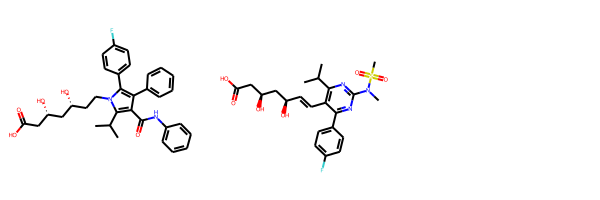

In [2]:

atorvastatin = Chem.MolFromSmiles('O=C(O)C[C@H](O)C[C@H](O)CCn2c(c(c(c2c1ccc(F)cc1)c3ccccc3)C(=O)Nc4ccccc4)C(C)C')
rosuvastatin = Chem.MolFromSmiles('OC(=O)C[C@H](O)C[C@H](O)\C=C\c1c(C(C)C)nc(N(C)S(=O)(=O)C)nc1c2ccc(F)cc2')
Draw.MolsToGridImage((atorvastatin,rosuvastatin))

In [3]:

def show_png(data):
    bio = io.BytesIO(data)
    img = Image.open(bio)
    return img

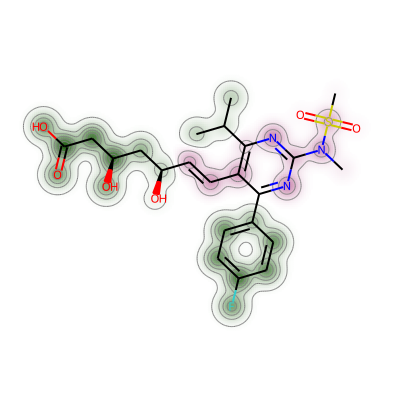

In [10]:

d = Draw.MolDraw2DCairo(400, 400)
a, maxWeight = SimilarityMaps.GetSimilarityMapForFingerprint(atorvastatin, rosuvastatin, 
                                        lambda m, i: SimilarityMaps.GetMorganFingerprint(m, i, radius=2, fpType='bv'), 
                                        draw2d=d)
d.FinishDrawing()
show_png(d.GetDrawingText())

In [11]:
maxWeight

0.11519364448857994

In [12]:
a

In [6]:
bio = io.BytesIO(d.GetDrawingText())

In [7]:
bio

In [13]:
d.GetDrawingText()

b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01\x90\x00\x00\x01\x90\x08\x02\x00\x00\x00\x0f\xdd\xa1\x9b\x00\x00\x00\x06bKGD\x00\xff\x00\xff\x00\xff\xa0\xbd\xa7\x93\x00\x00 \x00IDATx\x9c\xec\xbdw\x98\\\xdbU\'\xba\xd6\xde\xa7ruW\xe7\x9c$\xb5Z9\xb5rN\xf7\xea\x06g\xc3c`0\x86\xc77\xc6\x0c<\xe0\x83!3\x0c|\xdf\xbc\x87\xcd0\xf0l\x0c\x1e\xfc\x98a\x98\x81o\xc0cc\xe3\xc8\xe5\x06\xddke\xb5Z9K-u\xb7B+t\xb7:V<g\xaf\xf5\xfe\xd8\xfb\x9c\xaa\xbe\xc1\xd87Hjy\xff\xbe{K\xdd\xd5\xa7\xaaN\xeds\xf6o\xaf\xf5[a#3\x83\x85\x85\x85\xc5l\x80x\xd4\'`aaa\xf1\xbd\xc2\x12\x96\x85\x85\xc5\xac\x81%,\x0b\x0b\x8bY\x03KX\x16\x16\x16\xb3\x06\x96\xb0,,,f\r,aYXX\xcc\x1aX\xc2\xb2\xb0\xb0\x985\xb0\x84eaa1k`\t\xcb\xc2\xc2b\xd6\xc0\x12\x96\x85\x85\xc5\xac\x81%,\x0b\x0b\x8bY\x03KX\x16\x16\x16\xb3\x06\x96\xb0,,,f\r,aYXX\xcc\x1aX\xc2\xb2\xb0\xb0\x985\xb0\x84eaa1k`\t\xcb\xc2\xc2b\xd6\xc0\x12\x96\x85\x85\xc5\xac\x81%,\x0b\x0b\x8bY\x03KX\x16\x16\x16\xb3\x06\x96\xb0,,,f\r,aYXX\xcc\x1aX\xc2\xb2\xb0\xb0\x985\xb0\x84eaa1k`\t\xcb\xc2\xc2b

In [7]:
import pandas as pd
import os
path_data = '/nfs/turbo/umms-welchjd/hengshi/GAN/data/sciPlex/sciPlex3/'
data_188 = pd.read_csv(os.path.join(path_data, 'emb_named_chemvae_canonize.csv'))
chem_188 = list(data_188['Structure_Canonize'])

smiles_list_trans = []
for i in chem_188:
    if '.' in i:
        smile = ''
        for j in i: 
            if j != '.':
                smile += j
        smiles_list_trans.append(smile)
    else:
        smiles_list_trans.append(i)



smiles_list_trans1 = []
for i in smiles_list_trans:
    if '*' in i:
        smile = ''
        for j in i: 
            if j != '*':
                smile += j
        smiles_list_trans1.append(smile)
    else:
        smiles_list_trans1.append(i)

smiles_list_trans2 = []
for i in smiles_list_trans1:
    if 'a' in i:
        smile = ''
        for j in i: 
            if j != 'a':
                smile += j
        smiles_list_trans2.append(smile)
    else:
        smiles_list_trans2.append(i)




for i in range(len(smiles_list_trans2)):
    if len(smiles_list_trans2[i]) > 120:
        temp = smiles_list_trans2[i][:120]
        smiles_list_trans2[i] = temp
        

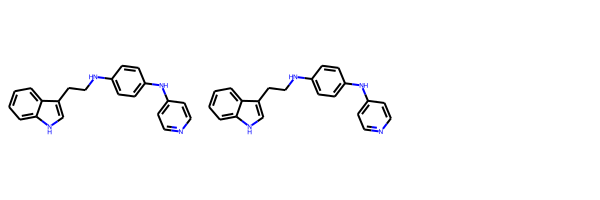

In [8]:

atorvastatin = Chem.MolFromSmiles(chem_188[0])
rosuvastatin = Chem.MolFromSmiles(smiles_list_trans2[0])
Draw.MolsToGridImage((atorvastatin,rosuvastatin))